In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball as pyb
import matplotlib as mpl

In [2]:
print(pyb.playerid_lookup('Judge','Aaron'))
batter_id = 669911
season = 2024
df_pyb = pyb.statcast_batter('2024-03-28', '2024-10-01', batter_id)
sorted_columns = sorted(df_pyb.columns)
print(sorted_columns)
df_pyb.head()

#print(df['column_name'].unique())

Gathering player lookup table. This may take a moment.
  name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0     judge      aaron     592450  judga001  judgeaa01          15640   

   mlb_played_first  mlb_played_last  
0            2016.0           2024.0  
Gathering Player Data
['age_bat', 'age_bat_legacy', 'age_pit', 'age_pit_legacy', 'api_break_x_arm', 'api_break_x_batter_in', 'api_break_z_with_gravity', 'arm_angle', 'at_bat_number', 'away_score', 'away_team', 'ax', 'ay', 'az', 'babip_value', 'balls', 'bat_score', 'bat_score_diff', 'bat_speed', 'bat_win_exp', 'batter', 'batter_days_since_prev_game', 'batter_days_until_next_game', 'bb_type', 'break_angle_deprecated', 'break_length_deprecated', 'delta_home_win_exp', 'delta_pitcher_run_exp', 'delta_run_exp', 'des', 'description', 'effective_speed', 'estimated_ba_using_speedangle', 'estimated_slg_using_speedangle', 'estimated_woba_using_speedangle', 'events', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fie

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,FF,2024-09-29,92.3,-0.93,5.70,"Toglia, Michael",669911,689017,field_out,hit_into_play,...,2,1,5.0,1.0,10.0,NaN,1.12,0.69,-0.69,52.3
1,CH,2024-09-29,85.4,0.64,5.76,"Toglia, Michael",669911,681911,single,hit_into_play,...,1,2,4.0,1.0,6.0,NaN,2.34,0.58,-0.58,55.2
2,FF,2024-09-29,99.3,-2.48,5.40,"Toglia, Michael",669911,656629,strikeout,swinging_strike,...,1,3,3.0,1.0,6.0,NaN,1.16,0.93,-0.93,38.4
3,FF,2024-09-29,92.4,0.25,5.87,"Toglia, Michael",669911,681911,NaN,ball,...,1,2,4.0,1.0,6.0,NaN,1.24,0.37,-0.37,60.5
4,FC,2024-09-29,91.3,-2.64,5.39,"Toglia, Michael",669911,656629,NaN,swinging_strike,...,1,3,3.0,1.0,6.0,NaN,2.59,-0.28,0.28,34.8


In [3]:
def df_processing(df_pyb: pd.DataFrame):
    df = df_pyb.copy()
    # Define the codes for different types of swings and whiffs
    swing_code = ['foul_bunt','foul','hit_into_play','swinging_strike', 'foul_tip',
                'swinging_strike_blocked','missed_bunt','bunt_foul_tip']
    whiff_code = ['swinging_strike', 'foul_tip', 'swinging_strike_blocked']

    # Create new columns in the DataFrame to indicate swing, whiff, in-zone, out-zone, and chase
    df['swing'] = (df['description'].isin(swing_code))
    df['whiff'] = (df['description'].isin(whiff_code))
    df['in_zone'] = (df['zone'] < 10)
    df['out_zone'] = (df['zone'] > 10)
    df['chase'] = (df.in_zone==False) & (df.swing == 1)

    # Convert the pitch type to a categorical variable
    df['pfx_z'] = df['pfx_z'] * 12
    df['pfx_x'] = df['pfx_x'] * 12
    return df

df = df_processing(df_pyb)

In [4]:
import pandas as pd
from pybaseball import statcast_outs_above_average
from pybaseball import statcast_catcher_framing

# All fielders with at least 50 fielding attempts in 2019
statcast_oaa = statcast_outs_above_average(season, "all", 50)

statcast_oaa.rename(columns={"player_id": "xMLBAMID"}, inplace=True)
statcast_oaa.rename(columns={"outs_above_average": "OAA"}, inplace=True)

# Catchers with at least 500 called pitches from 2019
statcast_catch = statcast_catcher_framing(season, min_called_p = 5)

statcast_catch.rename(columns={"player_id": "xMLBAMID"}, inplace=True)
statcast_catch.rename(columns={"runs_extra_strikes": "CFR"}, inplace=True)

defense_df = pd.merge(
    statcast_oaa, 
    statcast_catch, 
    on="xMLBAMID",      # merge on the common column; adjust if needed
    how="outer",       # use 'inner' to keep only players in both dfs, or 'outer' to keep all
    suffixes=("_oaa", "_catch")  # suffix overlapping column names
)

print(defense_df.columns)   # Correct usage

Index(['last_name, first_name', 'xMLBAMID', 'display_team_name', 'year_oaa',
       'primary_pos_formatted', 'fielding_runs_prevented', 'OAA',
       'outs_above_average_infront', 'outs_above_average_lateral_toward3bline',
       'outs_above_average_lateral_toward1bline', 'outs_above_average_behind',
       'outs_above_average_rhh', 'outs_above_average_lhh',
       'actual_success_rate_formatted', 'adj_estimated_success_rate_formatted',
       'diff_success_rate_formatted', 'last_name', 'first_name', 'year_catch',
       'n_called_pitches', 'CFR', 'strike_rate', 'strike_rate_11',
       'strike_rate_12', 'strike_rate_13', 'strike_rate_14', 'strike_rate_16',
       'strike_rate_17', 'strike_rate_18', 'strike_rate_19'],
      dtype='object')


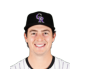

In [5]:
from PIL import Image
import requests
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Function to get an image from a URL and display it on the given axis
def player_headshot(batter_id: str, ax: plt.Axes):
    # Construct the URL for the player's headshot image
    url = f'https://img.mlbstatic.com/mlb-photos/image/'\
          f'upload/d_people:generic:headshot:67:current.png'\
          f'/w_640,q_auto:best/v1/people/{batter_id}/headshot/silo/current.png'

    # Send a GET request to the URL
    response = requests.get(url)

    # Open the image from the response content
    img = Image.open(BytesIO(response.content))


    # Display the image on the axis
    ax.set_xlim(0, 1.3)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0, 1, 0, 1], origin='upper')

    # Turn off the axis
    ax.axis('off')


# Call the player_headshot function with the pitcher ID and current axis
player_headshot(batter_id=batter_id, ax=plt.subplots(figsize=(1, 1))[1])

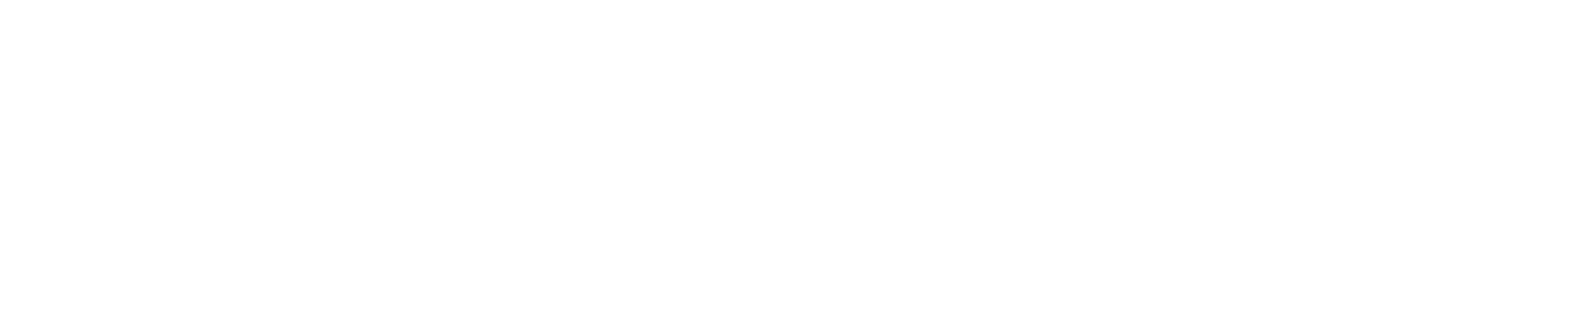

In [6]:
def player_bio(pitcher_id: str, ax: plt.Axes):
    # Construct the URL to fetch player data
    url = f"https://statsapi.mlb.com/api/v1/people?personIds={batter_id}&hydrate=currentTeam"

    # Send a GET request to the URL and parse the JSON response
    data = requests.get(url).json()

    # Extract player information from the JSON data
    player_name = data['people'][0]['fullName']
    batter_throw = data['people'][0]['pitchHand']['code']
    batter_hand = data['people'][0]['batSide']['code']
    position = data['people'][0]['primaryPosition']['abbreviation']
    age = data['people'][0]['currentAge']
    height = data['people'][0]['height']
    weight = data['people'][0]['weight']

    # Display the player's name, handedness, age, height, and weight on the axis
    ax.text(0.5, 1, f'{player_name}', va='top', ha='center', fontsize=50, color='white')
    ax.text(0.5, 0.65, f'{position}  {batter_hand}/{batter_throw}  Age:{age}  {height}/{weight}', va='top', ha='center', fontsize=30, color='white')
    ax.text(0.5, 0.40, f'{season} Season Hitter Summary', va='top', ha='center', fontsize=40, fontstyle='italic', color='white')
    ax.text(0.5, 0.15, f'', va='top', ha='center', fontsize=30, fontstyle='italic', color='white')

    # Turn off the axis
    ax.axis('off')

# Call the player_bio function with the pitcher ID and a new axis of size 10x2
player_bio(batter_id, ax=plt.subplots(figsize=(20, 4))[1])

In [7]:
import requests

def fangraphs_batting_leaderboards(season: int):
    url = f"https://www.fangraphs.com/api/leaders/major-league/data?age=&pos=all&stats=bat&lg=all&season={season}&season1={season}&ind=0&qual=0&type=0&month=0&pageitems=500000"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['data'])
    return df

# Example usage:
df_fangraphs = fangraphs_batting_leaderboards(season=season)
pd.set_option('display.max_columns', None)

# Example usage:
df_fangraphs = fangraphs_batting_leaderboards(season=season)
print(list(df_fangraphs.columns))
df_fangraphs.head()

['Bats', 'xMLBAMID', 'Name', 'Team', 'Season', 'Age', 'AgeR', 'SeasonMin', 'SeasonMax', 'G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'AVG', 'GB', 'FB', 'LD', 'IFFB', 'Pitches', 'Balls', 'Strikes', 'IFH', 'BU', 'BUH', 'BB%', 'K%', 'BB/K', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH%', 'BUH%', 'TTO%', 'wOBA', 'wRAA', 'wRC', 'Batting', 'Fielding', 'Replacement', 'Positional', 'wLeague', 'CFraming', 'Defense', 'Offense', 'RAR', 'WAR', 'WAROld', 'Dollars', 'BaseRunning', 'Spd', 'wRC+', 'wBsR', 'WPA', '-WPA', '+WPA', 'RE24', 'REW', 'pLI', 'phLI', 'PH', 'WPA/LI', 'Clutch', 'FB%1', 'FBv', 'SL%', 'SLv', 'CT%', 'CTv', 'CB%', 'CBv', 'CH%', 'CHv', 'SF%', 'SFv', 'KN%', 'KNv', 'XX%', 'PO%', 'wFB', 'wSL', 'wCT', 'wCB', 'wCH', 'wSF', 'wKN', 'wFB/C', 'wSL/C', 'wCT/C', 'wCB/C', 'wCH/C', 'wSF/C', 'wKN/C', 'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%', 'Zone%', 'F-

,Bats,xMLBAMID,Name,Team,Season,Age,AgeR,SeasonMin,SeasonMax,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,AVG,GB,FB,LD,IFFB,Pitches,Balls,Strikes,IFH,BU,BUH,BB%,K%,BB/K,OBP,SLG,OPS,ISO,BABIP,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH%,BUH%,TTO%,wOBA,wRAA,wRC,Batting,Fielding,Replacement,Positional,wLeague,CFraming,Defense,Offense,RAR,WAR,WAROld,Dollars,BaseRunning,Spd,wRC+,wBsR,WPA,-WPA,+WPA,RE24,REW,pLI,phLI,PH,WPA/LI,Clutch,FB%1,FBv,SL%,SLv,CT%,CTv,CB%,CBv,CH%,CHv,SF%,SFv,KN%,KNv,XX%,PO%,wFB,wSL,wCT,wCB,wCH,wSF,wKN,wFB/C,wSL/C,wCT/C,wCB/C,wCH/C,wSF/C,wKN/C,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,CStr%,C+SwStr%,Pull,Cent,Oppo,Soft,Med,Hard,bipCount,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,UBR,GDPRuns,AVG+,BB%+,K%+,OBP+,SLG+,ISO+,BABIP+,LD%+,GB%+,FB%+,HRFB%+,Pull%+,Cent%+,Oppo%+,Soft%+,Med%+,Hard%+,xwOBA,xAVG,xSLG,XBR,PPTV,CPTV,BPTV,DSV,DGV,BTV,rPPTV,rCPTV,rBPTV,rDSV,rDGV,rBTV,EBV,ESV,rFTeamV,rBTeamV,rTV,pfxFA%,pfxFT%,pfxFC%,pfxFS%,pfxFO%,pfxSI%,pfxSL%,pfxCU%,pfxKC%,pfxEP%,pfxCH%,pfxSC%,pfxKN%,pfxUN%,pfxvFA,pfxvFT,pfxvFC,pfxvFS,pfxvFO,pfxvSI,pfxvSL,pfxvCU,pfxvKC,pfxvEP,pfxvCH,pfxvSC,pfxvKN,pfxFA-X,pfxFT-X,pfxFC-X,pfxFS-X,pfxFO-X,pfxSI-X,pfxSL-X,pfxCU-X,pfxKC-X,pfxEP-X,pfxCH-X,pfxSC-X,pfxKN-X,pfxFA-Z,pfxFT-Z,pfxFC-Z,pfxFS-Z,pfxFO-Z,pfxSI-Z,pfxSL-Z,pfxCU-Z,pfxKC-Z,pfxEP-Z,pfxCH-Z,pfxSC-Z,pfxKN-Z,pfxwFA,pfxwFT,pfxwFC,pfxwFS,pfxwFO,pfxwSI,pfxwSL,pfxwCU,pfxwKC,pfxwEP,pfxwCH,pfxwSC,pfxwKN,pfxwFA/C,pfxwFT/C,pfxwFC/C,pfxwFS/C,pfxwFO/C,pfxwSI/C,pfxwSL/C,pfxwCU/C,pfxwKC/C,pfxwEP/C,pfxwCH/C,pfxwSC/C,pfxwKN/C,pfxO-Swing%,pfxZ-Swing%,pfxSwing%,pfxO-Contact%,pfxZ-Contact%,pfxContact%,pfxZone%,pfxPace,piCH%,piCS%,piCU%,piFA%,piFC%,piFS%,piKN%,piSB%,piSI%,piSL%,piXX%,pivCH,pivCS,pivCU,pivFA,pivFC,pivFS,pivKN,pivSB,pivSI,pivSL,pivXX,piCH-X,piCS-X,piCU-X,piFA-X,piFC-X,piFS-X,piKN-X,piSB-X,piSI-X,piSL-X,piXX-X,piCH-Z,piCS-Z,piCU-Z,piFA-Z,piFC-Z,piFS-Z,piKN-Z,piSB-Z,piSI-Z,piSL-Z,piXX-Z,piwCH,piwCS,piwCU,piwFA,piwFC,piwFS,piwKN,piwSB,piwSI,piwSL,piwXX,piwCH/C,piwCS/C,piwCU/C,piwFA/C,piwFC/C,piwFS/C,piwKN/C,piwSB/C,piwSI/C,piwSL/C,piwXX/C,piO-Swing%,piZ-Swing%,piSwing%,piO-Contact%,piZ-Contact%,piContact%,piZone%,piPace,Events,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Q,TG,TPA,PlayerNameRoute,PlayerName,position,playerid,TeamName,TeamNameAbb,teamid,Pos
0,R,592450,"<a href=""statss.aspx?playerid=15640&position=O...","<a href=""leaders.aspx?pos=all&stats=bat&lg=all...",2024,32.0,32 - 32,2024,2024,158.0,559.0,704.0,180.0,85.0,36.0,1.0,58.0,122.0,144.0,133.0,20.0,171.0,9.0,2.0,0.0,22.0,10.0,0.0,0.322004,119.0,180.0,91.0,10.0,2887.0,1252.0,1635.0,10.0,0.0,0.0,0.188920,0.242898,0.777778,0.458037,0.701252,1.159289,0.379249,0.367470,0.661111,0.233333,0.305128,0.461538,0.055556,0.322222,0.084034,0.0,0.514205,0.475734,93.807033,176.159595,95.394438,-6.765109,21.286834,-3.431070,2.218151,NaN,-10.196179,94.956920,108.265726,11.181438,11.432550,89.451507,-0.437518,3.920110,218.425380,0.366269,6.172045,-9.348380,15.520425,96.762001,10.102310,0.921447,NaN,0.0,9.473153,-2.774946,0.438475,94.638449,0.266551,84.804941,0.091161,89.498099,0.067244,80.654639,0.105719,85.636964,0.030849,86.606742,NaN,NaN,0.025286,None,48.395939,18.839394,6.161950,1.334982,5.172042,5.859716,NaN,3.825766,2.449856,2.342947,0.688135,1.695751,6.583950,NaN,0.212566,0.719120,0.420104,0.488950,0.807059,0.712046,0.409705,0.518466,0.120887,0.146173,0.267059,156.0,136.0,98.0,28.0,176.0,186.0,391.0,0.400000,0.348718,0.251282,0.071795,0.451282,0.476923,1.7,-1.2,134.327089,232.530881,107.618077,148.296947,177.757361,245.018551,128.672299,119.675024,73.565126,118.265975,284.218051,98.008241,99.347115,104.326409,44.302393,85.466005,153.886688,0.479,0.310,0.723,-0.803787,2.0,0.0,0.0,0.0,0.0,0.0,0.163204,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.163204,0.000000,0.163204,0.267523,None,0.087786,0.030881,NaN,0.169327,0.275156,0.055864,0.008328,NaN,0.105135,NaN,NaN,None,94.832168,None,89.796049,86.632582,NaN,94.176438,84.847041,79.964595,81.266668,NaN,85.572936,NaN,NaN,-1.760485,

In [8]:
df_fangraphs = pd.merge(
    defense_df,
    df_fangraphs,
    on="xMLBAMID",     # common column
    how="outer",       # or "inner" if you only want players in both datasets
    suffixes=("_def", "_fang")
)

print(list(df_fangraphs.columns))


['last_name, first_name', 'xMLBAMID', 'display_team_name', 'year_oaa', 'primary_pos_formatted', 'fielding_runs_prevented', 'OAA', 'outs_above_average_infront', 'outs_above_average_lateral_toward3bline', 'outs_above_average_lateral_toward1bline', 'outs_above_average_behind', 'outs_above_average_rhh', 'outs_above_average_lhh', 'actual_success_rate_formatted', 'adj_estimated_success_rate_formatted', 'diff_success_rate_formatted', 'last_name', 'first_name', 'year_catch', 'n_called_pitches', 'CFR', 'strike_rate', 'strike_rate_11', 'strike_rate_12', 'strike_rate_13', 'strike_rate_14', 'strike_rate_16', 'strike_rate_17', 'strike_rate_18', 'strike_rate_19', 'Bats', 'Name', 'Team', 'Season', 'Age', 'AgeR', 'SeasonMin', 'SeasonMax', 'G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'AVG', 'GB', 'FB', 'LD', 'IFFB', 'Pitches', 'Balls', 'Strikes', 'IFH', 'BU', 'BUH', 'BB%', 'K%', 'BB/K', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'GB/FB', '

In [9]:
import pandas as pd

# List of MLB teams and their corresponding ESPN logo URLs
mlb_teams = [
    {"team": "AZ", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/ari.png&h=500&w=500"},
    {"team": "ATL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/atl.png&h=500&w=500"},
    {"team": "BAL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/bal.png&h=500&w=500"},
    {"team": "BOS", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/bos.png&h=500&w=500"},
    {"team": "CHC", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/chc.png&h=500&w=500"},
    {"team": "CWS", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/chw.png&h=500&w=500"},
    {"team": "CIN", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/cin.png&h=500&w=500"},
    {"team": "CLE", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/cle.png&h=500&w=500"},
    {"team": "COL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/col.png&h=500&w=500"},
    {"team": "DET", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/det.png&h=500&w=500"},
    {"team": "HOU", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/hou.png&h=500&w=500"},
    {"team": "KC", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/kc.png&h=500&w=500"},
    {"team": "LAA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/laa.png&h=500&w=500"},
    {"team": "LAD", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/lad.png&h=500&w=500"},
    {"team": "MIA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/mia.png&h=500&w=500"},
    {"team": "MIL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/mil.png&h=500&w=500"},
    {"team": "MIN", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/min.png&h=500&w=500"},
    {"team": "NYM", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/nym.png&h=500&w=500"},
    {"team": "NYY", "logo_url": "https://a.espncdn.com/guid/2b9cedf3-ce60-0bcf-fafe-8cd055255685/logos/secondary_logo_on_black_color.png"},
    {"team": "ATH", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/oak.png&h=500&w=500"},
    {"team": "PHI", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/phi.png&h=500&w=500"},
    {"team": "PIT", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/pit.png&h=500&w=500"},
    {"team": "SD", "logo_url": "https://a.espncdn.com/guid/4dec648c-3eb9-055c-aebc-2711f30975a0/logos/primary_logo_on_black_color.png"},
    {"team": "SF", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sf.png&h=500&w=500"},
    {"team": "SEA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sea.png&h=500&w=500"},
    {"team": "STL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/stl.png&h=500&w=500"},
    {"team": "TB", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tb.png&h=500&w=500"},
    {"team": "TEX", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tex.png&h=500&w=500"},
    {"team": "TOR", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tor.png&h=500&w=500"},
    {"team": "WSH", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/wsh.png&h=500&w=500"}
]

# Create a DataFrame from the list of dictionaries
df_image = pd.DataFrame(mlb_teams)
image_dict = df_image.set_index('team')['logo_url'].to_dict()

In [10]:
import requests

def get_mlb_team_abbr(batter_id: int) -> str:
    """Fetch the MLB team abbreviation for a given player, filtering out non-MLB teams."""
    
    # Step 1: Request player data
    url = f"https://statsapi.mlb.com/api/v1/people?personIds={batter_id}&hydrate=currentTeam"
    data = requests.get(url).json()

    # Debugging: Print raw response
    print("Raw API Response:", data)

    # Step 2: Extract the current team details
    if 'people' in data and data['people']:
        current_team = data['people'][0].get('currentTeam', {})

        # If the current team exists, fetch its full details
        if 'link' in current_team:
            team_url = f"https://statsapi.mlb.com{current_team['link']}"
            team_data = requests.get(team_url).json()

            # Debugging: Print team data
            print("Team Data:", team_data)

            # Step 3: Check if the team belongs to MLB (sport ID = 1)
            if 'teams' in team_data and team_data['teams']:
                team_info = team_data['teams'][0]
                if team_info.get('sport', {}).get('id') == 1:  # Ensure it's MLB
                    return team_info.get('abbreviation', 'Unknown')
    
    return None  # Return None if no MLB team is found

# Example
batter_id = batter_id  # Oneil Cruz
mlb_team = get_mlb_team_abbr(batter_id)
print(f"MLB Team: {mlb_team}")  # Should return 'PIT'


Raw API Response: {'copyright': 'Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt', 'people': [{'id': 669911, 'fullName': 'Michael Toglia', 'link': '/api/v1/people/669911', 'firstName': 'Michael', 'lastName': 'Toglia', 'primaryNumber': '4', 'birthDate': '1998-08-16', 'currentAge': 26, 'birthCity': 'Phoenix', 'birthStateProvince': 'AZ', 'birthCountry': 'USA', 'height': '6\' 5"', 'weight': 226, 'active': True, 'currentTeam': {'id': 115, 'name': 'Colorado Rockies', 'link': '/api/v1/teams/115'}, 'primaryPosition': {'code': '3', 'name': 'First Base', 'type': 'Infielder', 'abbreviation': '1B'}, 'useName': 'Michael', 'useLastName': 'Toglia', 'middleName': 'Anthony', 'boxscoreName': 'Toglia', 'gender': 'M', 'isPlayer': True, 'isVerified': True, 'draftYear': 2019, 'mlbDebutDate': '2022-08-30', 'batSide': {'code': 'S', 'description': 'Switch'}, 'pitchHand': {'code': 'L', 'descripti

In [11]:
# #LOGOS FOR DOMINICAN LEAGUE PLAYERS

# def get_last_mlb_team(batter_id: int, season: int) -> str:
#     """Retrieve the last known MLB team for a player based on their most recent plate appearance."""
#     url = f"https://statsapi.mlb.com/api/v1/people/{batter_id}/stats?stats=gameLog&season={season}"
#     data = requests.get(url).json()

#     # Extract game logs
#     stats = data.get("stats", [])
#     if stats:
#         game_logs = stats[0].get("splits", [])
        
#         # Filter only MLB appearances (MLB team IDs are between 108-148)
#         mlb_games = [game for game in game_logs if game.get("team", {}).get("id") in range(108, 149)]

#         if mlb_games:
#             # Get the most recent game
#             last_game = mlb_games[-1]
#             team_data = last_game.get("team", {})

#             # Extract and return the team name (or we can map ID -> abbreviation)
#             return team_data.get("name", "Unknown")

#     return None  # Return None if no valid MLB team is found

# # Example: Oneil Cruz
# season = 2024  # Adjust season as needed
# mlb_team = get_last_mlb_team(batter_id, season)
# print(f"MLB Team (from last plate appearance in {season}): {mlb_team}")


# # Mapping of MLB team names to their abbreviations
# team_name_to_abbr = {
#     "Arizona Diamondbacks": "AZ",
#     "Atlanta Braves": "ATL",
#     "Baltimore Orioles": "BAL",
#     "Boston Red Sox": "BOS",
#     "Chicago Cubs": "CHC",
#     "Chicago White Sox": "CWS",
#     "Cincinnati Reds": "CIN",
#     "Cleveland Guardians": "CLE",
#     "Colorado Rockies": "COL",
#     "Detroit Tigers": "DET",
#     "Houston Astros": "HOU",
#     "Kansas City Royals": "KC",
#     "Los Angeles Angels": "LAA",
#     "Los Angeles Dodgers": "LAD",
#     "Miami Marlins": "MIA",
#     "Milwaukee Brewers": "MIL",
#     "Minnesota Twins": "MIN",
#     "New York Mets": "NYM",
#     "New York Yankees": "NYY",
#     "Oakland Athletics": "OAK",
#     "Philadelphia Phillies": "PHI",
#     "Pittsburgh Pirates": "PIT",
#     "San Diego Padres": "SD",
#     "San Francisco Giants": "SF",
#     "Seattle Mariners": "SEA",
#     "St. Louis Cardinals": "STL",
#     "Tampa Bay Rays": "TB",
#     "Texas Rangers": "TEX",
#     "Toronto Blue Jays": "TOR",
#     "Washington Nationals": "WSH"
# }

# def get_last_mlb_team_abbr(batter_id: int, season: int) -> str:
#     """Retrieve the last known MLB team abbreviation for a player based on their most recent plate appearance."""
#     url = f"https://statsapi.mlb.com/api/v1/people/{batter_id}/stats?stats=gameLog&season={season}"
#     data = requests.get(url).json()

#     stats = data.get("stats", [])
#     if stats:
#         game_logs = stats[0].get("splits", [])
        
#         # Filter only MLB appearances
#         mlb_games = [game for game in game_logs if game.get("team", {}).get("id") in range(108, 149)]

#         if mlb_games:
#             last_game = mlb_games[-1]  # Most recent game
#             team_name = last_game.get("team", {}).get("name", "Unknown")

#             # Convert team name to abbreviation
#             return team_name_to_abbr.get(team_name, "Unknown")

#     return None  # Return None if no valid team is found
# import matplotlib.pyplot as plt
# from PIL import Image
# import requests
# from io import BytesIO

# def plot_logo(batter_id: int, season: int, ax: plt.Axes):
#     """Fetch and plot a player's team logo based on their most recent MLB appearance."""
#     team_abbr = get_last_mlb_team_abbr(batter_id, season)
    
#     if team_abbr in image_dict:
#         logo_url = image_dict[team_abbr]
#         response = requests.get(logo_url)
#         img = Image.open(BytesIO(response.content))

#         # Display the image on the axis
#         ax.set_xlim(0, 1.3)
#         ax.set_ylim(0, 1)
#         ax.imshow(img, extent=[0.3, 1.3, 0, 1], origin='upper')

#         # Turn off the axis
#         ax.axis('off')
#     else:
#         print(f"Error: No logo found for team {team_abbr}")

# season = season  # Adjust season as needed

# fig, ax = plt.subplots(figsize=(1, 1))
# plot_logo(batter_id, season, ax)
# plt.show()



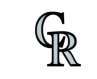

In [12]:
#LOGOS FOR MLB PLAYERS

def plot_logo(batter_id: str, ax: plt.Axes):
    # Construct the URL to fetch player data
    url = f"https://statsapi.mlb.com/api/v1/people?personIds={batter_id}&hydrate=currentTeam"

    # Send a GET request to the URL and parse the JSON response
    data = requests.get(url).json()

    # Construct the URL to fetch team data
    url_team = 'https://statsapi.mlb.com/' + data['people'][0]['currentTeam']['link']

    # Send a GET request to the team URL and parse the JSON response
    data_team = requests.get(url_team).json()

    # Extract the team abbreviation
    team_abb = data_team['teams'][0]['abbreviation']

    # Get the logo URL from the image dictionary using the team abbreviation
    logo_url = image_dict[team_abb]

    # Send a GET request to the logo URL
    response = requests.get(logo_url)

    # Open the image from the response content
    img = Image.open(BytesIO(response.content))

    # Display the image on the axis
    ax.set_xlim(0, 1.3)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0.3, 1.3, 0, 1], origin='upper')

    # Turn off the axis
    ax.axis('off')

# Call the plot_logo function with the pitcher ID and a new axis of size 1x1
plot_logo(batter_id, ax=plt.subplots(figsize=(1, 1))[1])

In [13]:
import ssl
import urllib.request
import io
from PIL import Image

def manual_logo(ax, logo_source):
    """
    Display a logo in the provided axis.
    
    logo_source: URL or local file path to the logo image.
    ax: The matplotlib axis on which to display the logo.
    """
    if logo_source.startswith('http'):
        # Create an unverified SSL context (use with caution)
        context = ssl._create_unverified_context()
        with urllib.request.urlopen(logo_source, context=context) as url:
            f = io.BytesIO(url.read())
        image = Image.open(f)
    else:
        # Otherwise assume it's a file path
        image = Image.open(logo_source)
    
    ax.imshow(image)
    ax.axis('off')  # Hide axis ticks


In [14]:
fangraphs_stats_dict = {
    'G': {'table_header': '$\\bf{G}$', 'format': '.0f'},         # Integer
    'Season': {'table_header': '$\\bf{Season}$', 'format': '.0f'}, # Integer
    'PA': {'table_header': '$\\bf{PA}$', 'format': '.0f'},       # Integer
    'HR': {'table_header': '$\\bf{HR}$', 'format': '.0f'},       # Integer
    'R': {'table_header': '$\\bf{R}$', 'format': '.0f'},         # Integer (Runs)
    'RBI': {'table_header': '$\\bf{RBI}$', 'format': '.0f'},     # Integer (Runs Batted In)
    'SB': {'table_header': '$\\bf{SB}$', 'format': '.0f'},       # Integer (Stolen Bases)
    'AVG': {'table_header': '$\\bf{AVG}$', 'format': '.3f'},     # Float (3 decimals)
    'OBP': {'table_header': '$\\bf{OBP}$', 'format': '.3f'},     # Float (3 decimals)
    'SLG': {'table_header': '$\\bf{SLG}$', 'format': '.3f'},     # Float (3 decimals)
    'OPS': {'table_header': '$\\bf{OPS}$', 'format': '.3f'},     # Float (3 decimals)
    'ISO': {'table_header': '$\\bf{ISO}$', 'format': '.3f'},     # Float (3 decimals)
    'WAR': {'table_header': '$\\bf{WAR}$', 'format': '.1f'},     # Float (1 decimal)
    'wOBA': {'table_header': '$\\bf{wOBA}$', 'format': '.3f'},   # Float (3 decimals)
    'xwOBA': {'table_header': '$\\bf{xwOBA}$', 'format': '.3f'}, # Float (3 decimals)
    'BABIP': {'table_header': '$\\bf{BABIP}$', 'format': '.3f'}, # Float (3 decimals)
    'K%': {'table_header': '$\\bf{K\\%}$', 'format': '.1f'},     # Percentage (1 decimal)
    'BB%': {'table_header': '$\\bf{BB\\%}$', 'format': '.1f'},   # Percentage (1 decimal)
    'wRC+': {'table_header': '$\\bf{wRC+}$', 'format': '.0f'},   # Integer (rounded)
    'LA': {'table_header': '$\\bf{LA}$', 'format': '.1f'},       # Float (1 decimal)
    'EV': {'table_header': '$\\bf{EV}$', 'format': '.1f'},       # Float (1 decimal)
    'maxEV': {'table_header': '$\\bf{maxEV}$', 'format': '.1f'}, # Float (1 decimal)
    'HardHit%': {'table_header': '$\\bf{HardHit\\%}$', 'format': '.1f'}, # Percentage (1 decimal)
    'Barrel%': {'table_header': '$\\bf{Barrel\\%}$', 'format': '.1f'},   # Percentage (1 decimal)
    'Z-Swing%': {'table_header': '$\\bf{Z-Swing\\%}$', 'format': '.1f'}, # Percentage (1 decimal)
    'O-Swing%': {'table_header': '$\\bf{O-Swing\\%}$', 'format': '.1f'}, # Percentage (1 decimal)
    'O-Contact%' : {'table_header': '$\\bf{O-Contact\\%}$', 'format': '.1f'}, # Percentage (1 decimal)
    'Z-Contact%': {'table_header': '$\\bf{Z-Contact\\%}$', 'format': '.1f'}, # Percentage (1 decimal)
    'Chase%': {'table_header': '$\\bf{Chase\\%}$', 'format': '.1f'},     # Percentage (1 decimal)
    'OAA': {'table_header': '$\\bf{OAA}$', 'format': '.1f'},
    'CFR': {'table_header': '$\\bf{CFR}$', 'format': '.1f'},
    'DRS': {'table_header': '$\\bf{DRS}$', 'format': '.0f'}     # Integer
}


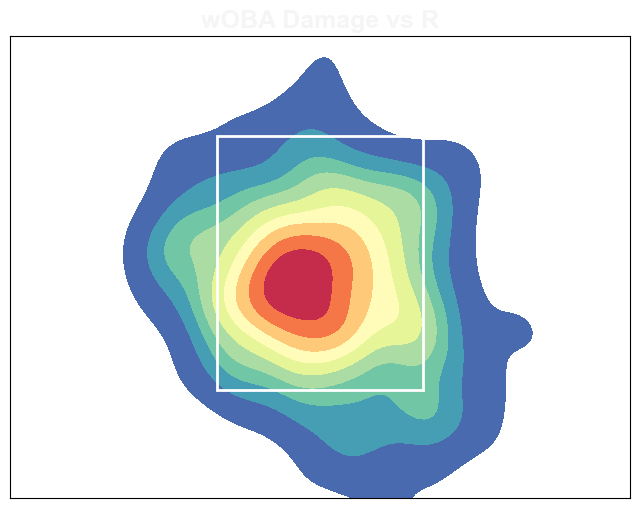

In [15]:
import matplotlib.patches as patches

def heatmap_R(df_pyb: pd.DataFrame, ax: plt.Axes):  # Add ax parameter here
    # Filter the DataFrame for left-handed pitchers and relevant columns
    filtered_R_df = df_pyb[
        (df_pyb['plate_x'].notnull()) & 
        (df_pyb['plate_z'].notnull()) & 
        (df_pyb['woba_value'].notnull()) & 
        (df_pyb['p_throws'] == 'R')
    ]

    # Create a DataFrame for the heatmap
    plate_damage_df = pd.DataFrame({
        'plate_x': filtered_R_df['plate_x'],
        'plate_z': filtered_R_df['plate_z'],
        'damage': filtered_R_df['woba_value']
    })

    # Define the corner coordinates for the rectangle
    min_plate_x = -0.83
    max_plate_x = 0.83
    min_plate_z = 1.17
    max_plate_z = 3.92

    # Create the heatmap on the provided axis
    sns.kdeplot(data=plate_damage_df, x='plate_x', y='plate_z', cmap='Spectral_r', fill=True, cbar=False, bw_adjust=0.9, ax=ax)

    # Create a rectangle using the given corner coordinates
    rectangle = patches.Rectangle(
        (min_plate_x, min_plate_z),  # Lower left corner
        max_plate_x - min_plate_x,   # Width
        max_plate_z - min_plate_z,   # Height
        linewidth=2,                 # Line width
        edgecolor='white',           # Rectangle border color
        facecolor='none',            # No fill color inside the rectangle
        linestyle='-'                # Solid line style
    )

    # Add the rectangle to the plot
    ax.add_patch(rectangle)

    # Set plot limits and aesthetics
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(0, 5)
    ax.set_xticks([])  # Remove x-axis numbers
    ax.set_yticks([])  # Remove y-axis numbers
    ax.grid(False)
    sns.set(style="white")

    # Add labels and title
    ax.set_title("wOBA Damage vs R", fontweight='bold', fontsize=18, color='#F5F5F5')
    ax.set_xlabel("")
    ax.set_ylabel("")

    return filtered_R_df

fig, ax = plt.subplots(figsize=(8, 6))
heatmap_R(df_pyb, ax)
plt.show()


In [16]:
# Check for all unique values in the 'zone' column to ensure zone 14 exists
unique_zones = df_pyb['zone'].unique()
print(unique_zones)

# Check if there is any data for zone 14
zone_14_data = df_pyb[df_pyb['zone'] == 14]
print(zone_14_data)


[ 5  3  4 12 14 13  7  8 11  9  2  1  6]
     pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
4            FC  2024-09-29           91.3          -2.64           5.39   
10           CU  2024-09-29           79.3          -1.03           5.94   
32           FC  2024-09-28           91.9          -1.45           5.39   
43           CU  2024-09-27           81.6          -1.12           6.13   
50           SL  2024-09-27           86.5          -2.95           5.57   
...         ...         ...            ...            ...            ...   
1897         ST  2024-03-31           83.4          -1.83           5.42   
1898         ST  2024-03-31           83.9          -1.90           5.36   
1907         FF  2024-03-31           93.9          -1.48           5.64   
1910         SL  2024-03-31           87.6          -2.05           6.44   
1912         SL  2024-03-31           87.0          -2.11           6.38   

          player_name  batter  pitcher        

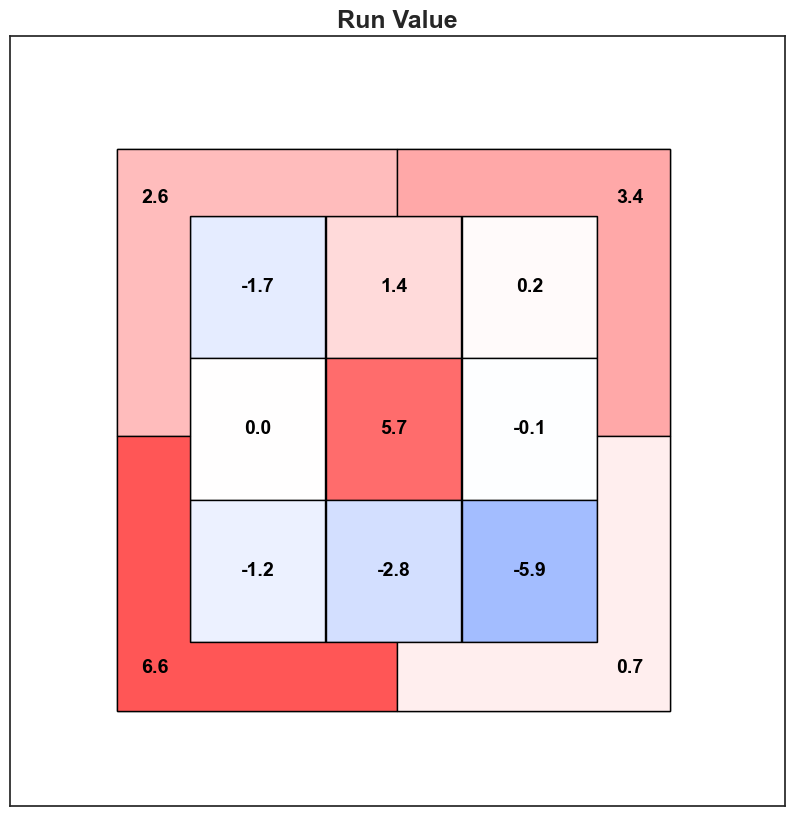

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import matplotlib.colors as mcolors

def statcast_run_value(df_pyb: pd.DataFrame, ax: plt.Axes, league_avg=0):
    # Filter the DataFrame for relevant columns and zones 1-14 (including zone 10 for calculations)
    filtered_df = df_pyb[
        (df_pyb['plate_x'].notnull()) & 
        (df_pyb['plate_z'].notnull()) & 
        (df_pyb['delta_run_exp'].notnull()) &
        (df_pyb['zone'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]))  # Zones 1-14
    ]
    
    # Define the custom colormap from blue to white to red
    cmap_sum = mcolors.LinearSegmentedColormap.from_list("", ['#648FFF','#FFFFFF','#FF0000'])
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    # Define square zones (1-9) and L-shaped zones (11-14)
    # Define square zones (1-9) and L-shaped zones (11-14)
    zones = [
        patches.Rectangle([-1.123, 1.17], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='white'),  # Zone 1
        patches.Rectangle([-0.42, 1.17], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 2
        patches.Rectangle([0.282, 1.17], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 3
        patches.Rectangle([-1.123, 2.09], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 4
        patches.Rectangle([-0.42, 2.09], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 5
        patches.Rectangle([0.282, 2.09], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 6
        patches.Rectangle([-1.123, 3.014], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'), # Zone 7
        patches.Rectangle([-0.42, 3.014], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 8
        patches.Rectangle([0.282, 3.014], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 9
    
        patches.Polygon([[-0.05, 3.935],[-0.05, 4.38], [-0.42, 1.8], [-1.25, 1.8],], closed=True, edgecolor='black', facecolor='lightgrey'),  # Zone 10
        patches.Polygon([[-1.5, 2.6], [-1.5, 0.735], [-0.05, 0.735], [-0.05,1.17],[-1.123, 1.17], [-1.123, 2.6]], closed=True, edgecolor='black', facecolor='lightgray'),   # Zone 11
        patches.Polygon([[-0.05, 0.735], [1.357, 0.735], [1.357, 2.6],[0.98, 2.6], [0.98, 1.17], [-0.05,1.17]], closed=True, edgecolor='black', facecolor='lightgrey'),  # Zone 12
        patches.Polygon([[-1.5, 2.6], [-1.123, 2.6], [-1.123, 3.935],[-0.05, 3.935],[-0.05, 4.38],[-1.5, 4.38]], closed=True, edgecolor='black', facecolor='lightgrey'),   # Zone 13
        patches.Polygon([[-0.05, 3.935],[-0.05, 4.38],[1.357, 4.38],[1.357, 2.6],[0.98, 2.6],[0.98, 3.935]], closed=True, edgecolor='black', facecolor='lightgrey'),  # Zone 14 (Invisible)
    ]
    
    # Add the 5x3 grid (each zone within the strike zone), skipping zone 10 from being plotted
    for i, zone in enumerate(zones):
        if i != 9:  # Skip zone 10 (index 9)
            ax.add_patch(zone)
    
    # Custom locations for the L-shaped zones (zones 11-14)
    custom_locations_L = {
        11: (-1.3, 1.05),  # Zone 11 custom position (L-shaped)
        12: (1.15, 1.05),   # Zone 12 custom position (L-shaped)
        13: (-1.3, 4.1),  # Zone 13 custom position (L-shaped)
        14: (1.15, 4.1),   # Zone 14 custom position (L-shaped)
    }
    
    # Calculate and place the run values for each zone (including zone 10)
    for i, zone in enumerate(zones):
        zone_num = i + 1  # Zones are numbered 1 through 14
        
        # Skip zone 10 from being plotted
        if i == 9:  # Zone 10 is invisible in the plot
            continue
        
        # Filter the DataFrame for pitches in this zone
        zone_data = filtered_df[filtered_df['zone'] == zone_num]
        
        # Sum the run values for this zone
        run_value = zone_data['delta_run_exp'].sum() if len(zone_data) > 0 else 0
        min_value = -10
        max_value = 10
        # Normalize the run value based on the user-defined min and max
        norm = mcolors.Normalize(vmin=min_value, vmax=max_value)
        norm_value = norm(run_value)  # Normalize the value
        
        # Get color from the colormap based on the normalized value
        color = cmap_sum(norm_value)  # Map the normalized value to the colormap
        
        # For L-shaped zones (11-14), use custom locations
        if zone_num in custom_locations_L:
            custom_x, custom_y = custom_locations_L[zone_num]
            ax.text(custom_x, custom_y, f'{run_value:.1f}', ha='center', va='center', fontsize=14, fontweight='bold', color='black')
            
            # Apply color based on run value for L-shaped zones
            polygon_vertices = zone.get_xy()  # Get the list of vertices for the polygon
            ax.add_patch(patches.Polygon(polygon_vertices, closed=True, edgecolor='black', facecolor=color, alpha=1))  
        else:
            # For square zones (1-9), place the value at the center of the zone
            if isinstance(zone, patches.Rectangle):  # For square zones
                x, y = zone.get_xy()
                x += zone.get_width() / 2
                y += zone.get_height() / 2
                # Manually define the four corners for the rectangle
                polygon_vertices = [
                    [x - zone.get_width() / 2, y - zone.get_height() / 2],
                    [x + zone.get_width() / 2, y - zone.get_height() / 2],
                    [x + zone.get_width() / 2, y + zone.get_height() / 2],
                    [x - zone.get_width() / 2, y + zone.get_height() / 2]
                ]
            elif isinstance(zone, patches.Polygon):  # For L-shaped zones
                polygon_vertices = zone.get_xy()  # Get the list of vertices for the polygon
            
            ax.text(x, y, f'{run_value:.1f}', ha='center', va='center', fontsize=14, fontweight='bold', color='black')
            
            # Apply color based on run value for square zones
            ax.add_patch(patches.Polygon(polygon_vertices, closed=True, edgecolor='black', facecolor=color, alpha=1))  

    # Set the title
    ax.set_title('Run Value', fontsize=18, fontweight='bold')
    
    # Set axis limits and aesthetics
    ax.set_xlim(-2.05, 1.95)
    ax.set_ylim(0, 5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    # Flip the y-axis to correctly position the zones (top to bottom)
    ax.invert_yaxis()

# Example usage:
statcast_run_value(df_pyb, ax)


In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import matplotlib.colors as mcolors

def statcast_run_value(df_pyb: pd.DataFrame, ax: plt.Axes, league_avg=0):
    # Filter the DataFrame for relevant columns and zones 1-14 (including zone 10 for calculations)
    filtered_df = df_pyb[
        (df_pyb['plate_x'].notnull()) & 
        (df_pyb['plate_z'].notnull()) & 
        (df_pyb['delta_run_exp'].notnull()) &
        (df_pyb['zone'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]))  # Zones 1-14
    ]
    
    # Define the custom colormap from blue to white to red
    cmap_sum = mcolors.LinearSegmentedColormap.from_list("", ['#648FFF','#FFFFFF','#FF0000'])
    
    # Define square zones (1-9) and L-shaped zones (11-14)
    zones = [
        patches.Rectangle([-1.123, 1.17], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 1
        patches.Rectangle([-0.42, 1.17], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 2
        patches.Rectangle([0.282, 1.17], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 3
        patches.Rectangle([-1.123, 2.09], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 4
        patches.Rectangle([-0.42, 2.09], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 5
        patches.Rectangle([0.282, 2.09], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 6
        patches.Rectangle([-1.123, 3.014], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'), # Zone 7
        patches.Rectangle([-0.42, 3.014], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 8
        patches.Rectangle([0.282, 3.014], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 9
    
        patches.Polygon([[-0.05, 3.935],[-0.05, 4.38], [-0.42, 1.8], [-1.25, 1.8],], closed=True, edgecolor='black', facecolor='lightgrey'),  # Zone 10
        patches.Polygon([[-1.5, 2.6], [-1.5, 0.735], [-0.05, 0.735], [-0.05,1.17],[-1.123, 1.17], [-1.123, 2.6]], closed=True, edgecolor='black', facecolor='lightgrey'),   # Zone 11
        patches.Polygon([[-0.05, 0.735], [1.357, 0.735], [1.357, 2.6],[0.98, 2.6], [0.98, 1.17], [-0.05,1.17]], closed=True, edgecolor='black', facecolor='lightgrey'),  # Zone 12
        patches.Polygon([[-1.5, 2.6], [-1.123, 2.6], [-1.123, 3.935],[-0.05, 3.935],[-0.05, 4.38],[-1.5, 4.38]], closed=True, edgecolor='black', facecolor='lightgrey'),   # Zone 13
        patches.Polygon([[-0.05, 3.935],[-0.05, 4.38],[1.357, 4.38],[1.357, 2.6],[0.98, 2.6],[0.98, 3.935]], closed=True, edgecolor='black', facecolor='lightgrey'),  # Zone 14 (Invisible)
    ]
    
    # Add the 5x3 grid (each zone within the strike zone), skipping zone 10 from being plotted
    for i, zone in enumerate(zones):
        if i != 9:  # Skip zone 10 (index 9)
            ax.add_patch(zone)
    
    # Custom locations for the L-shaped zones (zones 11-14)
    custom_locations_L = {
        11: (-1.3, 1.05),  # Zone 11 custom position (L-shaped)
        12: (1.15, 1.05),   # Zone 12 custom position (L-shaped)
        13: (-1.3, 4.1),  # Zone 13 custom position (L-shaped)
        14: (1.15, 4.1),   # Zone 14 custom position (L-shaped)
    }
    
    # Calculate and place the run values for each zone (including zone 10)
    for i, zone in enumerate(zones):
        zone_num = i + 1  # Zones are numbered 1 through 14
        
        # Skip zone 10 from being plotted
        if i == 9:  # Zone 10 is invisible in the plot
            continue
        
        # Filter the DataFrame for pitches in this zone
        zone_data = filtered_df[filtered_df['zone'] == zone_num]
        
        # Sum the run values for this zone
        run_value = zone_data['delta_run_exp'].sum() if len(zone_data) > 0 else 0
        min_value = -10
        max_value = 10
        # Normalize the run value based on the user-defined min and max
        norm = mcolors.Normalize(vmin=min_value, vmax=max_value)
        norm_value = norm(run_value)  # Normalize the value
        
        # Get color from the colormap based on the normalized value
        color = cmap_sum(norm_value)  # Map the normalized value to the colormap
        
        # For L-shaped zones (11-14), use custom locations
        if zone_num in custom_locations_L:
            custom_x, custom_y = custom_locations_L[zone_num]
            ax.text(custom_x, custom_y, f'{run_value:.1f}', ha='center', va='center', fontsize=14, fontweight='bold', color='black')
            
            # Apply color based on run value for L-shaped zones
            polygon_vertices = zone.get_xy()  # Get the list of vertices for the polygon
            ax.add_patch(patches.Polygon(polygon_vertices, closed=True, edgecolor='black', facecolor=color, alpha=1))  
        else:
            # For square zones (1-9), place the value at the center of the zone
            if isinstance(zone, patches.Rectangle):  # For square zones
                x, y = zone.get_xy()
                x += zone.get_width() / 2
                y += zone.get_height() / 2
                # Manually define the four corners for the rectangle
                polygon_vertices = [
                    [x - zone.get_width() / 2, y - zone.get_height() / 2],
                    [x + zone.get_width() / 2, y - zone.get_height() / 2],
                    [x + zone.get_width() / 2, y + zone.get_height() / 2],
                    [x - zone.get_width() / 2, y + zone.get_height() / 2]
                ]
            elif isinstance(zone, patches.Polygon):  # For L-shaped zones
                polygon_vertices = zone.get_xy()  # Get the list of vertices for the polygon
            
            ax.text(x, y, f'{run_value:.1f}', ha='center', va='center', fontsize=14, fontweight='bold', color='black')
            
            # Apply color based on run value for square zones
            ax.add_patch(patches.Polygon(polygon_vertices, closed=True, edgecolor='black', facecolor=color, alpha=1))  

    # Set the title
    ax.set_title('Run Value', fontsize=18, fontweight='bold', color = 'white')
    
    # Set axis limits and aesthetics
    ax.set_xlim(-2.15, 2.05)
    ax.set_ylim(0.55, 4.55)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    # Flip the y-axis to correctly position the zones (top to bottom)
    ax.invert_yaxis()

    # Do not call plt.show() here since it is handled by the dashboard
    # plt.show()  # Remove this line

statcast_run_value(df_pyb, ax)

In [19]:
#SCZ VS L

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import matplotlib.colors as mcolors

def statcast_run_value_L(df_pyb: pd.DataFrame, ax: plt.Axes, league_avg=0):
    # Filter the DataFrame for relevant columns, zones 1-14, and left-handed pitchers
    filtered_df = df_pyb[
        (df_pyb['plate_x'].notnull()) & 
        (df_pyb['plate_z'].notnull()) & 
        (df_pyb['delta_run_exp'].notnull()) &
        (df_pyb['zone'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])) &  # Zones 1-14
        (df_pyb['p_throws'] == 'L')  # Filter for left-handed pitchers
    ]
    
    # Define the custom colormap from blue to white to red
    cmap_sum = mcolors.LinearSegmentedColormap.from_list("", ['#3661AD','#FFFFFF','#D82129'])
    
    # Define square zones (1-9) and L-shaped zones (11-14)
    zones = [
        patches.Rectangle([-1.123, 1.17], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 1
        patches.Rectangle([-0.42, 1.17], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 2
        patches.Rectangle([0.282, 1.17], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 3
        patches.Rectangle([-1.123, 2.09], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 4
        patches.Rectangle([-0.42, 2.09], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 5
        patches.Rectangle([0.282, 2.09], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 6
        patches.Rectangle([-1.123, 3.014], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'), # Zone 7
        patches.Rectangle([-0.42, 3.014], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 8
        patches.Rectangle([0.282, 3.014], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 9
    
        patches.Polygon([[-0.05, 3.935],[-0.05, 4.38], [-0.42, 1.8], [-1.25, 1.8],], closed=True, edgecolor='black', facecolor='lightgrey'),  # Zone 10
        patches.Polygon([[-1.5, 2.6], [-1.5, 0.735], [-0.05, 0.735], [-0.05,1.17],[-1.123, 1.17], [-1.123, 2.6]], closed=True, edgecolor='black', facecolor='lightgrey'),   # Zone 11
        patches.Polygon([[-0.05, 0.735], [1.357, 0.735], [1.357, 2.6],[0.98, 2.6], [0.98, 1.17], [-0.05,1.17]], closed=True, edgecolor='black', facecolor='lightgrey'),  # Zone 12
        patches.Polygon([[-1.5, 2.6], [-1.123, 2.6], [-1.123, 3.935],[-0.05, 3.935],[-0.05, 4.38],[-1.5, 4.38]], closed=True, edgecolor='black', facecolor='lightgrey'),   # Zone 13
        patches.Polygon([[-0.05, 3.935],[-0.05, 4.38],[1.357, 4.38],[1.357, 2.6],[0.98, 2.6],[0.98, 3.935]], closed=True, edgecolor='black', facecolor='lightgrey'),  # Zone 14 (Invisible)
    ]
    
    # Add the 5x3 grid (each zone within the strike zone), skipping zone 10 from being plotted
    for i, zone in enumerate(zones):
        if i != 9:  # Skip zone 10 (index 9)
            ax.add_patch(zone)
    
    # Custom locations for the L-shaped zones (zones 11-14)
    custom_locations_L = {
        11: (-1.3, 1.05),  # Zone 11 custom position (L-shaped)
        12: (1.15, 1.05),   # Zone 12 custom position (L-shaped)
        13: (-1.3, 4.1),  # Zone 13 custom position (L-shaped)
        14: (1.15, 4.1),   # Zone 14 custom position (L-shaped)
    }
    
    # Calculate and place the run values for each zone (including zone 10)
    for i, zone in enumerate(zones):
        zone_num = i + 1  # Zones are numbered 1 through 14
        
        # Skip zone 10 from being plotted
        if i == 9:  # Zone 10 is invisible in the plot
            continue
        
        # Filter the DataFrame for pitches in this zone
        zone_data = filtered_df[filtered_df['zone'] == zone_num]
        
        # Sum the run values for this zone
        run_value = zone_data['delta_run_exp'].sum() if len(zone_data) > 0 else 0
        min_value = -7
        max_value = 7
        # Normalize the run value based on the user-defined min and max
        norm = mcolors.Normalize(vmin=min_value, vmax=max_value)
        norm_value = norm(run_value)  # Normalize the value
        
        # Get color from the colormap based on the normalized value
        color = cmap_sum(norm_value)  # Map the normalized value to the colormap
        
        # For L-shaped zones (11-14), use custom locations
        if zone_num in custom_locations_L:
            custom_x, custom_y = custom_locations_L[zone_num]
            ax.text(custom_x, custom_y, f'{run_value:.1f}', ha='center', va='center', fontsize=14, fontweight='bold', color='black')
            
            # Apply color based on run value for L-shaped zones
            polygon_vertices = zone.get_xy()  # Get the list of vertices for the polygon
            ax.add_patch(patches.Polygon(polygon_vertices, closed=True, edgecolor='black', facecolor=color, alpha=1))  
        else:
            # For square zones (1-9), place the value at the center of the zone
            if isinstance(zone, patches.Rectangle):  # For square zones
                x, y = zone.get_xy()
                x += zone.get_width() / 2
                y += zone.get_height() / 2
                # Manually define the four corners for the rectangle
                polygon_vertices = [
                    [x - zone.get_width() / 2, y - zone.get_height() / 2],
                    [x + zone.get_width() / 2, y - zone.get_height() / 2],
                    [x + zone.get_width() / 2, y + zone.get_height() / 2],
                    [x - zone.get_width() / 2, y + zone.get_height() / 2]
                ]
            elif isinstance(zone, patches.Polygon):  # For L-shaped zones
                polygon_vertices = zone.get_xy()  # Get the list of vertices for the polygon
            
            ax.text(x, y, f'{run_value:.1f}', ha='center', va='center', fontsize=14, fontweight='bold', color='black')
            
            # Apply color based on run value for square zones
            ax.add_patch(patches.Polygon(polygon_vertices, closed=True, edgecolor='black', facecolor=color, alpha=1))  

    # Set the title
    ax.set_title('Run Value vs L', fontsize=18, fontweight='bold', color = 'white')
    
    # Set axis limits and aesthetics
    ax.set_xlim(-2.15, 2.05)
    ax.set_ylim(0.55, 4.55)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    # Flip the y-axis to correctly position the zones (top to bottom)
    ax.invert_yaxis()

    # Do not call plt.show() here since it is handled by the dashboard
    # plt.show()  # Remove this line

# Example usage:
statcast_run_value_L(df_pyb, ax)


In [20]:
#SCZ VS R

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import matplotlib.colors as mcolors

def statcast_run_value_R(df_pyb: pd.DataFrame, ax: plt.Axes, league_avg=0):
    # Filter the DataFrame for relevant columns, zones 1-14, and left-handed pitchers
    filtered_df = df_pyb[
        (df_pyb['plate_x'].notnull()) & 
        (df_pyb['plate_z'].notnull()) & 
        (df_pyb['delta_run_exp'].notnull()) &
        (df_pyb['zone'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])) &  # Zones 1-14
        (df_pyb['p_throws'] == 'R')  # Filter for left-handed pitchers
    ]
    
    # Define the custom colormap from blue to white to red
    cmap_sum = mcolors.LinearSegmentedColormap.from_list("", ['#3661AD','#FFFFFF','#D82129'])
    
    # Define square zones (1-9) and L-shaped zones (11-14)
    zones = [
        patches.Rectangle([-1.123, 1.17], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 1
        patches.Rectangle([-0.42, 1.17], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 2
        patches.Rectangle([0.282, 1.17], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 3
        patches.Rectangle([-1.123, 2.09], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 4
        patches.Rectangle([-0.42, 2.09], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 5
        patches.Rectangle([0.282, 2.09], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),   # Zone 6
        patches.Rectangle([-1.123, 3.014], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'), # Zone 7
        patches.Rectangle([-0.42, 3.014], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 8
        patches.Rectangle([0.282, 3.014], 0.7, 0.92, linewidth=1, edgecolor='black', facecolor='lightgrey'),  # Zone 9
    
        patches.Polygon([[-0.05, 3.935],[-0.05, 4.38], [-0.42, 1.8], [-1.25, 1.8],], closed=True, edgecolor='black', facecolor='lightgrey'),  # Zone 10
        patches.Polygon([[-1.5, 2.6], [-1.5, 0.735], [-0.05, 0.735], [-0.05,1.17],[-1.123, 1.17], [-1.123, 2.6]], closed=True, edgecolor='black', facecolor='lightgrey'),   # Zone 11
        patches.Polygon([[-0.05, 0.735], [1.357, 0.735], [1.357, 2.6],[0.98, 2.6], [0.98, 1.17], [-0.05,1.17]], closed=True, edgecolor='black', facecolor='lightgrey'),  # Zone 12
        patches.Polygon([[-1.5, 2.6], [-1.123, 2.6], [-1.123, 3.935],[-0.05, 3.935],[-0.05, 4.38],[-1.5, 4.38]], closed=True, edgecolor='black', facecolor='lightgrey'),   # Zone 13
        patches.Polygon([[-0.05, 3.935],[-0.05, 4.38],[1.357, 4.38],[1.357, 2.6],[0.98, 2.6],[0.98, 3.935]], closed=True, edgecolor='black', facecolor='lightgrey'),  # Zone 14 (Invisible)
    ]
    
    # Add the 5x3 grid (each zone within the strike zone), skipping zone 10 from being plotted
    for i, zone in enumerate(zones):
        if i != 9:  # Skip zone 10 (index 9)
            ax.add_patch(zone)
    
    # Custom locations for the L-shaped zones (zones 11-14)
    custom_locations_R = {
        11: (-1.3, 1.05),  # Zone 11 custom position (L-shaped)
        12: (1.15, 1.05),   # Zone 12 custom position (L-shaped)
        13: (-1.3, 4.1),  # Zone 13 custom position (L-shaped)
        14: (1.15, 4.1),   # Zone 14 custom position (L-shaped)
    }
    
    # Calculate and place the run values for each zone (including zone 10)
    for i, zone in enumerate(zones):
        zone_num = i + 1  # Zones are numbered 1 through 14
        
        # Skip zone 10 from being plotted
        if i == 9:  # Zone 10 is invisible in the plot
            continue
        
        # Filter the DataFrame for pitches in this zone
        zone_data = filtered_df[filtered_df['zone'] == zone_num]
        
        # Sum the run values for this zone
        run_value = zone_data['delta_run_exp'].sum() if len(zone_data) > 0 else 0
        min_value = -7
        max_value = 7
        # Normalize the run value based on the user-defined min and max
        norm = mcolors.Normalize(vmin=min_value, vmax=max_value)
        norm_value = norm(run_value)  # Normalize the value
        
        # Get color from the colormap based on the normalized value
        color = cmap_sum(norm_value)  # Map the normalized value to the colormap
        
        # For L-shaped zones (11-14), use custom locations
        if zone_num in custom_locations_R:
            custom_x, custom_y = custom_locations_R[zone_num]
            ax.text(custom_x, custom_y, f'{run_value:.1f}', ha='center', va='center', fontsize=14, fontweight='bold', color='black')
            
            # Apply color based on run value for L-shaped zones
            polygon_vertices = zone.get_xy()  # Get the list of vertices for the polygon
            ax.add_patch(patches.Polygon(polygon_vertices, closed=True, edgecolor='black', facecolor=color, alpha=1))  
        else:
            # For square zones (1-9), place the value at the center of the zone
            if isinstance(zone, patches.Rectangle):  # For square zones
                x, y = zone.get_xy()
                x += zone.get_width() / 2
                y += zone.get_height() / 2
                # Manually define the four corners for the rectangle
                polygon_vertices = [
                    [x - zone.get_width() / 2, y - zone.get_height() / 2],
                    [x + zone.get_width() / 2, y - zone.get_height() / 2],
                    [x + zone.get_width() / 2, y + zone.get_height() / 2],
                    [x - zone.get_width() / 2, y + zone.get_height() / 2]
                ]
            elif isinstance(zone, patches.Polygon):  # For L-shaped zones
                polygon_vertices = zone.get_xy()  # Get the list of vertices for the polygon
            
            ax.text(x, y, f'{run_value:.1f}', ha='center', va='center', fontsize=14, fontweight='bold', color='black')
            
            # Apply color based on run value for square zones
            ax.add_patch(patches.Polygon(polygon_vertices, closed=True, edgecolor='black', facecolor=color, alpha=1))  

    # Set the title
    ax.set_title('Run Value vs R', fontsize=18, fontweight='bold', color = 'white')
    
    # Set axis limits and aesthetics
    ax.set_xlim(-2.15, 2.05)
    ax.set_ylim(0.55, 4.55)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    # Flip the y-axis to correctly position the zones (top to bottom)
    ax.invert_yaxis()

    # Do not call plt.show() here since it is handled by the dashboard
    # plt.show()  # Remove this line

# Example usage:
statcast_run_value_R(df_pyb, ax)


In [21]:
import matplotlib.patches as patches

def heatmap_L(df_pyb: pd.DataFrame, ax: plt.Axes):  # Add ax parameter here
    # Filter the DataFrame for left-handed pitchers and relevant columns
    filtered_L_df = df_pyb[
        (df_pyb['plate_x'].notnull()) & 
        (df_pyb['plate_z'].notnull()) & 
        (df_pyb['woba_value'].notnull()) & 
        (df_pyb['p_throws'] == 'L')
    ]

    # Create a DataFrame for the heatmap
    plate_damage_df = pd.DataFrame({
        'plate_x': filtered_L_df['plate_x'],
        'plate_z': filtered_L_df['plate_z'],
        'damage': filtered_L_df['woba_value']
    })

    # Define the corner coordinates for the rectangle
    min_plate_x = -0.83
    max_plate_x = 0.83
    min_plate_z = 1.17
    max_plate_z = 3.92

    # Create the heatmap on the provided axis
    sns.kdeplot(data=plate_damage_df, x='plate_x', y='plate_z', cmap='Spectral_r', fill=True, cbar=False, bw_adjust=0.9, ax=ax)

    # Create a rectangle using the given corner coordinates
    rectangle = patches.Rectangle(
        (min_plate_x, min_plate_z),  # Lower left corner
        max_plate_x - min_plate_x,   # Width
        max_plate_z - min_plate_z,   # Height
        linewidth=2,                 # Line width
        edgecolor='white',           # Rectangle border color
        facecolor='none',            # No fill color inside the rectangle
        linestyle='-'                # Solid line style
    )

    # Add the rectangle to the plot
    ax.add_patch(rectangle)

    # Set plot limits and aesthetics
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(0, 5)
    ax.set_xticks([])  # Remove x-axis numbers
    ax.set_yticks([])  # Remove y-axis numbers
    ax.grid(False)
    sns.set(style="white")

    # Add labels and title
    ax.set_title("wOBA Damage vs L", fontweight='bold', fontsize=18, color='#F5F5F5')
    ax.set_xlabel("")
    ax.set_ylabel("")

    return filtered_L_df


In [22]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator, FormatStrFormatter
# from matplotlib.collections import LineCollection
# from matplotlib.lines import Line2D
# def rolling_woba_by_pa(df: pd.DataFrame, ax: plt.Axes, window: int):
#     # Drop rows where 'woba_value' or 'plate_x' and 'plate_z' are NaN
#     df = df.dropna(subset=['woba_value', 'plate_x', 'plate_z'])

#     # Reverse the DataFrame order
#     df = df.iloc[::-1].reset_index(drop=True)
     
    
#     # Calculate wOBA rolling window by PA (plate appearance)
#     df['rolling_woba'] = df['woba_value'].rolling(window=window).mean()
    
#     # Generate x and y data for the plot
#     x = np.arange(len(df))
#     y = df['rolling_woba'].values

#     # Create segments for the LineCollection
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)

#     # Define color based on the y value crossing the 0.316 threshold
#     colors = ['blue' if y_ < 0.316 else 'red' for y_ in y]
#     cmap = plt.cm.get_cmap('coolwarm')  # Use a diverging colormap
#     lc = LineCollection(
#         segments, 
#         cmap=cmap, 
#         norm=plt.Normalize(vmin=0.19, vmax=0.42),  # Adjust normalization as needed
#         linewidth=2
#     )
#     lc.set_array(y)  # Color by y-values
#     ax.add_collection(lc)

#     # Plot the rolling wOBA against Plate Appearances
#     ax.plot(x, y, alpha=0)  # Transparent line for proper scaling
    
#     # Adjust axis labels and title with smaller fonts and closer to graph
#     ax.set_xlabel(' ', fontdict={'size':12}, fontweight='bold')  # Smaller x-axis label font size
#     ax.set_ylabel(' ', fontdict={'size': 12}, labelpad=-15, fontweight='bold')  # Smaller y-axis label font size and closer to the axis
#     ax.set_title(f'Rolling wOBA ({window} PA) in {season}', fontdict={'size': 18}, pad=5,fontweight='bold')  # Smaller title font size and adjusted padding

#     # Format y-axis to show three decimal places
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
#     # Set x-axis to show integer values only (i.e., PA numbers)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))

#     # Set font size for tick labels
#     ax.tick_params(axis='both', which='major', labelsize=11, labelleft=True, labelbottom=True)  # Smaller font size for tick labels
    
#     # Set the tick labels inside the graph
#     ax.tick_params(axis='x', direction='in', length=6)  # Move x-axis ticks inside
#     ax.tick_params(axis='y', direction='in', length=6)  # Move y-axis ticks inside
#     ax.tick_params(axis='x', labeltop=False, labelbottom=True, direction='inout', length=6, pad=-16)
    
#     ax.set_xticks(np.arange(0, len(df), 100))

#     # Optional: Adjust x and y axis limits
#     ax.set_xlim(50, len(df))  # Set x-axis range from 0 to the length of the data
#     ax.set_ylim(.1, 0.600)      # Example: limit y-axis to range from 0 to 0.5 for rolling wOBA
    
#     # Add dashed red line at y = 0.316 (MLB average)
#     ax.axhline(y=0.316, color='red', linestyle='--', linewidth=2)
    

#     xlim_right = ax.get_xlim()[1]

#     # Add label for the dashed line on the right side of the graph
#     ax.text(xlim_right * .95, 0.3, 'MLB avg', color='red', fontsize=9, va='center', ha='right')

#     plt.show()

# filtered_df = df_pyb[(df_pyb['events'].notnull())]
# # Example usage
# rolling_woba_by_pa(filtered_df, ax=plt.subplots(figsize=(10, 4))[1], window=50)


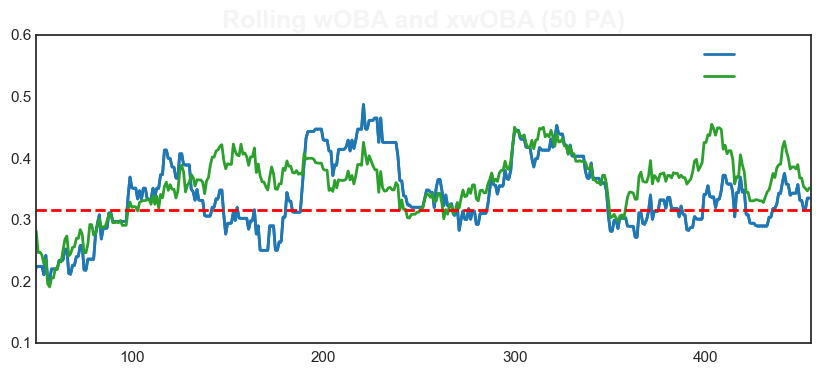

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

def rolling_woba_by_pa(df: pd.DataFrame, ax: plt.Axes, window: int):
    # Set the Seaborn style
    sns.set(style="whitegrid", palette="muted")  # Set style to whitegrid and muted color palette

    # Drop rows where 'woba_value' or 'plate_x' and 'plate_z' are NaN
    df = df.dropna(subset=['woba_value', 'plate_x', 'plate_z', 'estimated_woba_using_speedangle'])

    # Reverse the DataFrame order
    df = df.iloc[::-1].reset_index(drop=True)
     
    # Calculate wOBA rolling window by PA (plate appearance)
    df['rolling_woba'] = df['woba_value'].rolling(window=window).mean()
    df['rolling_xwoba'] = df['estimated_woba_using_speedangle'].rolling(window=window).mean()  # Calculate rolling xwOBA
    
    # Generate x and y data for the plot
    x = np.arange(len(df))
    y_woba = df['rolling_woba'].values
    y_xwoba = df['rolling_xwoba'].values

    # Create segments for the LineCollection for wOBA
    points = np.array([x, y_woba]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Remove the color map and set the wOBA line to blue
    lc = LineCollection(
        segments, 
        color='#1f77b4',  # Set color to a nice blue (Seaborn default)
        linewidth=2
    )
    ax.add_collection(lc)

    # Plot the rolling wOBA against Plate Appearances
    ax.plot(x, y_woba, color='#1f77b4', lw=2, label='wOBA')  # Plot rolling wOBA in blue
    ax.plot(x, y_xwoba, color='#2ca02c', lw=2, label='xwOBA')  # Plot rolling xwOBA in green
    
    # Adjust axis labels and title with smaller fonts and closer to graph
    ax.set_xlabel('', fontdict={'size':12}, fontweight='bold')  # Smaller x-axis label font size
    ax.set_ylabel('', fontdict={'size': 12}, labelpad=-15, fontweight='bold')  # Smaller y-axis label font size and closer to the axis
    ax.set_title(f'Rolling wOBA and xwOBA ({window} PA)', fontdict={'size': 18}, pad=5,fontweight='bold', color= '#F5F5F5')  # Smaller title font size and adjusted padding

    # Format y-axis to show three decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    # Set x-axis to show integer values only (i.e., PA numbers)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Set font size for tick labels
    ax.tick_params(axis='both', which='major', labelsize=11, labelleft=True, labelbottom=True)  # Smaller font size for tick labels
    
    # Set the tick labels inside the graph
    ax.tick_params(axis='x', direction='in', length=6)  # Move x-axis ticks inside
    ax.tick_params(axis='y', direction='in', length=6)  # Move y-axis ticks inside
    ax.tick_params(axis='x', labeltop=False, labelbottom=True, direction='inout', length=6, pad=3)
    
    ax.set_xticks(np.arange(0, len(df), 100))

    # Optional: Adjust x and y axis limits
    ax.set_xlim(50, len(df))  # Set x-axis range from 0 to the length of the data
    ax.set_ylim(.1, 0.600)      # Example: limit y-axis to range from 0 to 0.5 for rolling wOBA
    
    # Add dashed red line at y = 0.316 (MLB average)
    ax.axhline(y=0.316, color='red', linestyle='--', linewidth=2)
    
    blue_patch = Line2D([0], [0], color='#1f77b4', lw=2, label='wOBA', )
    green_patch = Line2D([0], [0], color='#2ca02c', lw=2, label='xwOBA',)
    avg_line = Line2D([0], [0], color='red', linestyle='--', lw=2, label='MLB Avg')
    
    ax.legend(handles=[blue_patch, green_patch, avg_line], fontsize=10, )
    ax.legend(frameon=False, labelcolor='white')
    ax.grid(False)
    plt.show()

# Example usage
filtered_df = df_pyb[(df_pyb['events'].notnull())]
rolling_woba_by_pa(filtered_df, ax=plt.subplots(figsize=(10, 4))[1], window=50)


In [24]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import colors

# Sample league averages for each stat (replace with actual data)
league_averages = {
    'AVG': 0.260,
    'OBP': 0.315,
    'SLG': 0.400,
    'OPS': 0.700,
    'ISO': 0.140,
    'WAR': 1.0,
    'wOBA': 0.310,
    'xwOBA': 0.312,
    'BABIP': 0.300,
    'K%': -21.3,
    'BB%': 8.0,
    'wRC+': 100,
    'LA': 13.5,
    'EV': 89.3,
    'maxEV': 109.,
    'HardHit%': 40.0,
    'Barrel%': 9.0,
    'Z-Swing%': 70.0,
    'O-Swing%': 30.0,
    'O-Contact%': 50.0,
    'Z-Contact%': 80.0,
    'Chase%': 28.2,
    'OAA': 0,
    'DRS': 0
}

In [25]:
df_ZIPS25 = pd.read_csv('ZIPS_proj2025.csv')
df_ZIPS22 = pd.read_csv('ZIPS_2022.csv')  # Data for 2022 season
df_ZIPS23 = pd.read_csv('ZIPS_2023.csv')  # Data for 2023 season
df_ZIPS24 = pd.read_csv('ZIPS_2024.csv')  # Data for 2024 season
df_ZIPS26 = pd.read_csv('ZIPS_proj2026.csv')  # Projected data for 2026 season
df_ZIPS27 = pd.read_csv('ZIPS_proj2027.csv')  # Projected data for 2027 season
df_actual22 = pd.read_csv('Actual_2022.csv')  # Actual data for 2022 season
df_actual23 = pd.read_csv('Actual_2023.csv')  # Actual data for 2023 season
df_actual24 = pd.read_csv('Actual_2024.csv')  # Actual data for 2024 season

print("Column names in df_ZIPS22:", df_ZIPS25.columns.tolist())

Column names in df_ZIPS22: ['Name', 'Team', 'G', 'PA', 'AB', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'AVG', 'BB%', 'K%', 'BB/K', 'OBP', 'SLG', 'wOBA', 'OPS', 'ISO', 'Spd', 'BABIP', 'UBR', 'wSB', 'wRC', 'wRAA', 'wRC+', 'BsR', 'Fld', 'Off', 'Def', 'WAR', 'ADP', 'InterSD', 'InterSK', 'IntraSD', 'Vol', 'Skew', 'Dim', 'FPTS', 'FPTS/G', 'SPTS', 'SPTS/G', 'P10', 'P20', 'P30', 'P40', 'P50', 'P60', 'P70', 'P80', 'P90', 'TT10', 'TT20', 'TT30', 'TT40', 'TT50', 'TT60', 'TT70', 'TT80', 'TT90', 'NameASCII', 'PlayerId', 'MLBAMID']


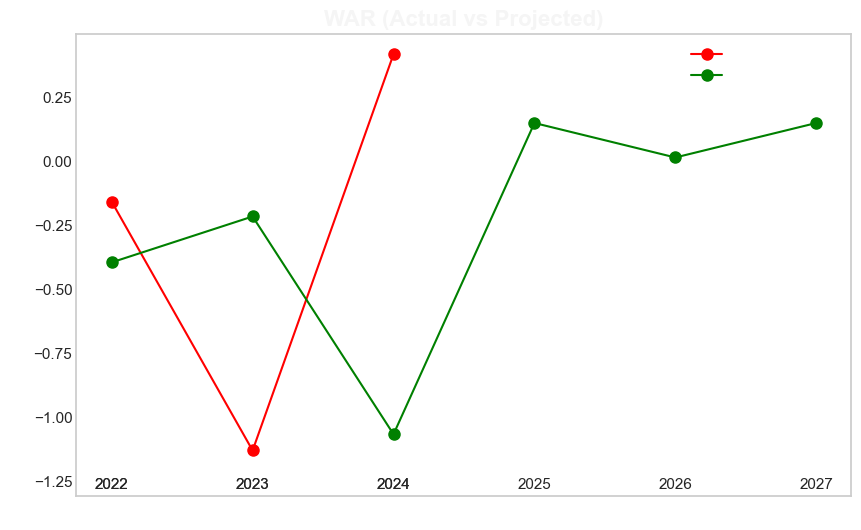

In [26]:
def plot_war_comparison(batter_id: int, df_actual22: pd.DataFrame, df_actual23: pd.DataFrame, df_actual24: pd.DataFrame, df_ZIPS22: pd.DataFrame, df_ZIPS23: pd.DataFrame, df_ZIPS24: pd.DataFrame, df_ZIPS25: pd.DataFrame, df_ZIPS26: pd.DataFrame, df_ZIPS27: pd.DataFrame, ax):
    # Initialize the lists for actual WAR and projected WAR
    actual_war = []
    projected_war = []
    actual_years = []
    projected_years = []

    # Extract actual WAR for available years (2022, 2023, 2024)
    for year, df in zip([2022, 2023, 2024], [df_actual22, df_actual23, df_actual24]):
        if batter_id in df['MLBAMID'].values:
            actual_war.append(df[df['MLBAMID'] == batter_id]['WAR'].values[0])
            actual_years.append(year)

    # Extract projected WAR for all relevant years (2022-2027)
    for year, df in zip([2022, 2023, 2024, 2025, 2026, 2027], [df_ZIPS22, df_ZIPS23, df_ZIPS24, df_ZIPS25, df_ZIPS26, df_ZIPS27]):
        if batter_id in df['MLBAMID'].values:
            projected_war.append(df[df['MLBAMID'] == batter_id]['WAR'].values[0])
            projected_years.append(year)

 
    ax.plot(actual_years, actual_war, label='Actual WAR', color='red', marker='o', linestyle='-', markersize=8)
    ax.plot(projected_years, projected_war, label='Projected WAR', color='green', marker='o', linestyle='-', markersize=8)

    # Customize the graph
    ax.set_title(f'WAR (Actual vs Projected)', fontsize=16, fontweight='bold', color='#F5F5F5')
    ax.set_xlabel(' ', fontsize=14)
    ax.set_ylabel(' ', fontsize=14)

    # Ensure the x-axis shows only the relevant years
    ax.set_xticks(actual_years + projected_years)  # Combine the actual and projected years for the x-axis

    # Remove grid lines
    ax.grid(False)

    # Move the x-axis labels inside the plot area
    ax.tick_params(axis='x', labeltop=False, labelbottom=True, direction='inout', length=6, pad=-16)  # pad=-10 brings the labels inside
    ax.tick_params(axis='y', pad=-3)

    # Set the y-axis limits to move the lowest tick up
    y_min, y_max = ax.get_ylim()  # Get current y-axis limits
    ax.set_ylim(y_min - 0.06 * (y_max - y_min), y_max)  # Adjust the lower limit (move up by 10%)

    # Add legend with white text color
    ax.legend(frameon=False, labelcolor='white')

plot_war_comparison(batter_id, df_actual22, df_actual23, df_actual24, df_ZIPS22, df_ZIPS23, df_ZIPS24, df_ZIPS25, df_ZIPS26, df_ZIPS27, ax=plt.subplots(figsize=(10, 6))[1])


In [27]:

# def proj_fangraphs_batter_stats(batter_id: int, ax: plt.Axes, stats: list, season: int, projection_csv: str, fontsize: int = 20):
#     df_fangraphs = fangraphs_batting_leaderboards(season=season)
#     df_ZIPS25 = pd.read_csv(projection_csv)

#     batter_id = int(batter_id)

#     # Filter both datasets using xMLBAMID
#     df_fg_batter = df_fangraphs[df_fangraphs['xMLBAMID'] == batter_id][stats].reset_index(drop=True)
#     df_ZIPS25_batter = df_ZIPS25[df_ZIPS25['MLBAMID'] == batter_id][stats].reset_index(drop=True)

#     if df_fg_batter.empty or df_ZIPS25_batter.empty:
#         print(f"No data found for batter ID {batter_id} in either dataset.")
#         return

#     # Convert percentage stats
#     for stat in stats:
#         if '%' in stat:
#             df_fg_batter[stat] = df_fg_batter[stat] * 100
#             df_ZIPS25_batter[stat] = df_ZIPS25_batter[stat] * 100

#     # Format stats to three decimal places
#     # Format the DataFrame values based on fangraphs_stats_dict
#     for stat in stats:
#         if stat in fangraphs_stats_dict:
#             format_str = fangraphs_stats_dict[stat]['format']
#             df_fg_batter[stat] = df_fg_batter[stat].apply(lambda x: format(float(x), format_str))
#             df_ZIPS25_batter[stat] = df_ZIPS25_batter[stat].apply(lambda x: format(float(x), format_str))


#     # Create table data (Actual 2024 + ZIPS Projections 2025)
#     table_data = [df_fg_batter.iloc[0].tolist(), df_ZIPS25_batter.iloc[0].tolist()]

#     # Create the table
#     table_fg = ax.table(cellText=table_data, 
#                     rowLabels=['2024', 'ZIPS'], 
#                     colLabels=stats, 
#                     cellLoc='center', 
#                     bbox=[0.00, 0.0, 1, 1])

# # Apply a light green tint to the second row (ZIPS 2025)
#     for i in range(len(stats)):  # Iterate through each column in the row
#         table_fg[(2, i)].set_facecolor('#d8f3dc')  # Light green color

    

#     # Custom normalization ranges for each stat based on league averages
#     custom_normalization = {
#             'AVG': {'vmin': 0.200, 'vmax': 0.320},  # Lower bound for batting average
#             'OBP': {'vmin': 0.245, 'vmax': 0.385},
#             'SLG': {'vmin': 0.300, 'vmax': 0.500},
#             'OPS': {'vmin': 0.450, 'vmax': .950},
#             'ISO': {'vmin': 0.075, 'vmax': 0.300},
#             'WAR': {'vmin': -6.0, 'vmax': 6.0},  # WAR can go above 10
#             'wOBA': {'vmin': 0.230, 'vmax': 0.390},
#             'xwOBA': {'vmin': 0.240, 'vmax': 0.395},
#             'BABIP': {'vmin': 0.270, 'vmax': 0.330},
#             'K%': {'vmin': -32.0, 'vmax': -13.0},  # Flip range for K%
#             'BB%': {'vmin': 3.0, 'vmax': 13.0},
#             'wRC+': {'vmin': 40, 'vmax': 160},
#             'LA': {'vmin': 5.0, 'vmax': 25.0},
#             'EV': {'vmin': 85, 'vmax': 94},
#             'maxEV': {'vmin': 103, 'vmax': 115},
#             'HardHit%': {'vmin': 22.0, 'vmax': 57.0},
#             'Barrel%': {'vmin': 1.0, 'vmax': 17.0},
#             'Z-Swing%': {'vmin': 55.0, 'vmax': 85.0},
#             'O-Swing%': {'vmin': -45.0, 'vmax': -15.0},  # Flip range for O-Swing%
#             'O-Contact%': {'vmin': 30.0, 'vmax': 70.0},
#             'Z-Contact%': {'vmin': 70.0, 'vmax': 90.0},
#             'Chase%': {'vmin': 10.0, 'vmax': 50.0},
#             'OAA': {'vmin': -20, 'vmax': 20},  # For fielding, OAA is best when positive
#             'DRS': {'vmin': -20, 'vmax': 20},  # For fielding, DRS is best when positive
#         }

#     # Normalize the stats values based on league averages
#     for i, stat in enumerate(stats):
#         league_avg = league_averages.get(stat, None)
#         if league_avg:
#             # Explicitly ensure that the stat value is a float
#             stat_value = float(df_fg_batter[stat].iloc[0])  # Convert to float

#             # Handle flipped stats
#             if stat in ['K%', 'O-Swing%']:
#                 # Flip the stat value for normalization and adjust range
#                 stat_value = -stat_value

#             # Use the custom normalization for each stat if defined
#             if stat in custom_normalization:
#                 norm_params = custom_normalization[stat]
#                 vmin, vmax = norm_params['vmin'], norm_params['vmax']
#             else:
#                 # Default to a broader range for other stats if no custom range is provided
#                 vmin = league_avg * 0.8  # Normal range for other stats
#                 vmax = league_avg * 1.2

#             # Apply the color mapping
#             norm = colors.Normalize(vmin=vmin, vmax=vmax)
#             cmap = plt.get_cmap('coolwarm')  # Blue to Red gradient
#             color = ScalarMappable(norm=norm, cmap=cmap).to_rgba(stat_value)

#             # Apply color to the cell
#             table_fg[(1, i)].set_facecolor(color)  # Cell at row 1 (stat row)

#     # Set font size and styling
#     for key, cell in table_fg.get_celld().items():
#         if cell._text:
#             cell._text.set_fontsize(fontsize)
#     for i, key in enumerate(stats):
#         table_fg[0, i]._text.set_fontweight('bold')  # Column headers bold

#     ax.axis('off')

# # Example call
# batter_id = batter_id  # Example batter ID
# stats = ['G', 'PA', 'HR','R','RBI','SB', 'K%', 'BB%','AVG', 'OBP', 'SLG', 'OPS','wRC+','wOBA', 'WAR']
# season = season
# projection_csv = "ZIPS_proj2025.csv"  # Path to your ZIPS projections CSV

# fig, ax = plt.subplots(figsize=(10, 2))
# proj_fangraphs_batter_stats(batter_id=batter_id, ax=ax, stats=stats, season=season, projection_csv=projection_csv)
# plt.show()

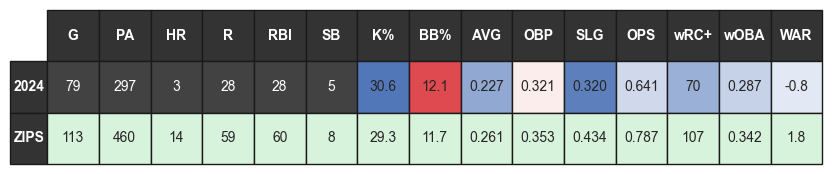

In [51]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define color maps
cmap_sum = mcolors.LinearSegmentedColormap.from_list("", ['#3661AD','#FFFFFF','#D82129'])
cmap_sum_r = mcolors.LinearSegmentedColormap.from_list("", ['#D82129','#FFFFFF','#3661AD'])

# Function to get color
def get_color(value, normalize, cmap):
    color = cmap(normalize(value))
    return mcolors.to_hex(color)

# Update function with color mapping
def proj_fangraphs_batter_stats(batter_id: int, ax: plt.Axes, stats: list, season: int, projection_csv: str, fontsize: int = 20):
    # df_fangraphs = fangraphs_batting_leaderboards(season=season)
    df_ZIPS25 = pd.read_csv(projection_csv)

    batter_id = int(batter_id)

    # Filter both datasets using xMLBAMID
    df_fangraphs_batter = df_fangraphs[df_fangraphs['xMLBAMID'] == batter_id][stats].reset_index(drop=True)
    df_ZIPS25_batter = df_ZIPS25[df_ZIPS25['MLBAMID'] == batter_id][stats].reset_index(drop=True)

    if df_fangraphs_batter.empty or df_ZIPS25_batter.empty:
        print(f"No data found for batter ID {batter_id} in either dataset.")
        return

    # Convert percentage stats
    for stat in stats:
        if '%' in stat:
            df_fangraphs_batter[stat] = df_fangraphs_batter[stat] * 100
            df_ZIPS25_batter[stat] = df_ZIPS25_batter[stat] * 100

    # Format stats based on dictionary
    for stat in stats:
        if stat in fangraphs_stats_dict:
            format_str = fangraphs_stats_dict[stat]['format']
            df_fangraphs_batter[stat] = df_fangraphs_batter[stat].apply(lambda x: format(float(x), format_str))
            df_ZIPS25_batter[stat] = df_ZIPS25_batter[stat].apply(lambda x: format(float(x), format_str))

    # Create table data (Actual 2024 + ZIPS Projections 2025)
    table_data = [df_fangraphs_batter.iloc[0].tolist(), df_ZIPS25_batter.iloc[0].tolist()]

    # Create the table
    
    table_fg = ax.table(cellText=table_data, 
                    rowLabels=[season, 'ZIPS'], 
                    colLabels=stats,

                    cellLoc='center', 
                    bbox=[0.00, 0.0, 1, 1])
    #now color the rowlabels and set the text to white anad make them bold
    for i, label in enumerate(['2024', 'ZIPS']):
        cell = table_fg[(i+1, -1)],
        cell[0].set_facecolor('#333333'),
        cell[0]._text.set_color('white'),
        cell[0]._text.set_fontweight('bold'),
    

    # Apply light green tint to the ZIPS 2025 row
    for i in range(len(stats)):  
        table_fg[(2, i)].set_facecolor('#d8f3dc')  

    # Custom normalization ranges for each stat
    custom_normalization = {
        'AVG': {'vmin': 0.200, 'vmax': 0.320},
        'OBP': {'vmin': 0.245, 'vmax': 0.385},
        'SLG': {'vmin': 0.300, 'vmax': 0.500},
        'OPS': {'vmin': 0.450, 'vmax': .950},
        'ISO': {'vmin': 0.075, 'vmax': 0.300},
        'WAR': {'vmin': -6.0, 'vmax': 6.0},
        'wOBA': {'vmin': 0.230, 'vmax': 0.390},
        'xwOBA': {'vmin': 0.240, 'vmax': 0.395},
        'BABIP': {'vmin': 0.270, 'vmax': 0.330},
        'K%': {'vmin': -32.0, 'vmax': -13.0},  
        'BB%': {'vmin': 3.0, 'vmax': 13.0},
        'wRC+': {'vmin': 40, 'vmax': 160},
        'LA': {'vmin': 5.0, 'vmax': 25.0},
        'EV': {'vmin': 85, 'vmax': 94},
        'maxEV': {'vmin': 103, 'vmax': 115},
        'HardHit%': {'vmin': 22.0, 'vmax': 57.0},
        'Barrel%': {'vmin': 1.0, 'vmax': 17.0},
        'Z-Swing%': {'vmin': 55.0, 'vmax': 85.0},
        'O-Swing%': {'vmin': -45.0, 'vmax': -15.0},  
        'O-Contact%': {'vmin': 30.0, 'vmax': 70.0},
        'Z-Contact%': {'vmin': 70.0, 'vmax': 90.0},
        'Chase%': {'vmin': 10.0, 'vmax': 50.0},
        'OAA': {'vmin': -20, 'vmax': 20},
        'DRS': {'vmin': -20, 'vmax': 20},
    }

    #  Apply color mapping
    for i, stat in enumerate(stats):
        if stat in custom_normalization:
            vmin, vmax = custom_normalization[stat]['vmin'], custom_normalization[stat]['vmax']
            normalize = mcolors.Normalize(vmin=vmin, vmax=vmax)

            stat_value = float(df_fangraphs_batter[stat].iloc[0])

            # Handle flipped stats (like K% and O-Swing%)
            if stat in ['K%', 'O-Swing%']:
                stat_value = -stat_value

            # Use reversed colormap for xwOBA
            cmap = cmap_sum
            color = get_color(stat_value, normalize, cmap)

            # Apply color to the table cell
            table_fg[(1, i)].set_facecolor(color)

    # Adjust text size and headers
    for key, cell in table_fg.get_celld().items():
        if cell._text:
            cell._text.set_fontsize(fontsize)
    
    # Set dark background and white text for header cells
    for i, key in enumerate(stats):
        header_cell = table_fg[0, i]
        header_cell.set_facecolor('#333333')  # Dark background for header
        header_cell._text.set_fontweight('bold')
        header_cell._text.set_color('white')  # White text for the header

    # Apply a lighter dark color to the first six rows of column values, based on column names
    # Ensure that the rows being accessed exist
    num_rows = len(df_fangraphs_batter)
    rows_to_color = min(6, num_rows)  # Ensuring no out-of-range error

    # List of columns that you want to apply the lighter dark color to
    columns_to_color = ['G', 'PA', 'HR', 'R', 'RBI', 'SB']  # Example: Color only these columns

    for row in range(1, rows_to_color + 1):  # For rows 1 to 6 (skip header row 0)
        for col, stat in enumerate(stats):
            if stat in columns_to_color:  # Check if the column is one of the ones we want to color
                cell = table_fg[row, col]
                cell.set_facecolor('#424242')  # Apply a lighter dark background color for these cells
                cell._text.set_color('white')  # Apply white text color for these cells

    ax.axis('off')

# Example call
batter_id = batter_id  # Example batter ID
stats = ['G', 'PA', 'HR','R','RBI','SB', 'K%', 'BB%','AVG', 'OBP', 'SLG', 'OPS','wRC+','wOBA', 'WAR']
season = season
projection_csv = "ZIPS_proj2025.csv"  # Path to your ZIPS projections CSV

fig, ax = plt.subplots(figsize=(10, 2))
proj_fangraphs_batter_stats(batter_id=batter_id, ax=ax, stats=stats, season=season, projection_csv=projection_csv)
plt.show()

In [29]:

# def adv_fangraphs_batter_stats(batter_id: str, ax: plt.Axes, stats: list, season: int, fontsize: int = 20):
#     df_fangraphs = fangraphs_batting_leaderboards(season=season)

#     # Convert batter_id to integer to match the type of xMLBAMID
#     batter_id = int(batter_id)
    
#     # Filter data for the given batter ID
#     df_fangraphs_batter = df_fangraphs[df_fangraphs['xMLBAMID'] == batter_id][stats].reset_index(drop=True)
    
#     # Check if the batter is found
#     if df_fangraphs_batter.empty:
#         print(f"No data found for batter ID {batter_id}")
#     else:
#         print(df_fangraphs_batter)
    
#         # Ensure percentage stats are converted to float
#         for stat in stats:
#             if '%' in stat:  # For percentage metrics
#                 df_fangraphs_batter[stat] = df_fangraphs_batter[stat] * 100
        
#         # Format the stats as per the dictionary
#         df_fangraphs_batter.loc[0] = [
#             format(float(df_fangraphs_batter[stat].iloc[0]), fangraphs_stats_dict[stat]['format']) 
#             for stat in stats
#         ]
#         # Create the table
#         table_fg = ax.table(cellText=df_fangraphs_batter.values, colLabels=stats, cellLoc='center', bbox=[0.00, 0.0, 1, 1])

#         # Custom normalization ranges for each stat based on league averages
#         custom_normalization = {
#             'AVG': {'vmin': 0.200, 'vmax': 0.320},  # Lower bound for batting average
#             'OBP': {'vmin': 0.245, 'vmax': 0.385},
#             'SLG': {'vmin': 0.300, 'vmax': 0.500},
#             'OPS': {'vmin': 0.450, 'vmax': .950},
#             'ISO': {'vmin': 0.075, 'vmax': 0.300},
#             'WAR': {'vmin': -6.0, 'vmax': 6.0},  # WAR can go above 10
#             'wOBA': {'vmin': 0.230, 'vmax': 0.390},
#             'xwOBA': {'vmin': 0.240, 'vmax': 0.395},
#             'BABIP': {'vmin': 0.270, 'vmax': 0.330},
#             'K%': {'vmin': -32.0, 'vmax': -13.0},  # Flip range for K%
#             'BB%': {'vmin': 3.0, 'vmax': 13.0},
#             'wRC+': {'vmin': 40, 'vmax': 160},
#             'LA': {'vmin': 5.0, 'vmax': 25.0},
#             'EV': {'vmin': 85, 'vmax': 94},
#             'maxEV': {'vmin': 103, 'vmax': 115},
#             'HardHit%': {'vmin': 22.0, 'vmax': 57.0},
#             'Barrel%': {'vmin': 1.0, 'vmax': 17.0},
#             'Z-Swing%': {'vmin': 60.0, 'vmax': 80.0},
#             'O-Swing%': {'vmin': -45.0, 'vmax': -15.0},  # Flip range for O-Swing%
#             'O-Contact%': {'vmin': 30.0, 'vmax': 70.0},
#             'Z-Contact%': {'vmin': 70.0, 'vmax': 90.0},
#             'Chase%': {'vmin': 10.0, 'vmax': 50.0},
#             'OAA': {'vmin': -20, 'vmax': 20},  # For fielding, OAA is best when positive
#             'DRS': {'vmin': -20, 'vmax': 20},  # For fielding, DRS is best when positive
#         }

#         # Normalize the stats values based on league averages
#         for i, stat in enumerate(stats):
#             league_avg = league_averages.get(stat, None)
#             if league_avg:
#                 # Explicitly ensure that the stat value is a float
#                 stat_value = float(df_fangraphs_batter[stat].iloc[0])  # Convert to float

#                 # Handle flipped stats
#                 if stat in ['K%', 'O-Swing%']:
#                     # Flip the stat value for normalization and adjust range
#                     stat_value = -stat_value

#                 # Use the custom normalization for each stat if defined
#                 if stat in custom_normalization:
#                     norm_params = custom_normalization[stat]
#                     vmin, vmax = norm_params['vmin'], norm_params['vmax']
#                 else:
#                     # Default to a broader range for other stats if no custom range is provided
#                     vmin = league_avg * 0.8  # Normal range for other stats
#                     vmax = league_avg * 1.2

#                 # Apply the color mapping
#                 norm = colors.Normalize(vmin=vmin, vmax=vmax)
#                 cmap = plt.get_cmap('coolwarm')  # Blue to Red gradient
#                 color = ScalarMappable(norm=norm, cmap=cmap).to_rgba(stat_value)

#                 # Apply color to the cell
#                 table_fg[(1, i)].set_facecolor(color)  # Cell at row 1 (stat row)

#         # Set font size for each cell's text
#         for key, cell in table_fg.get_celld().items():
#             if cell._text:
#                 cell._text.set_fontsize(fontsize)
#         for i, key in enumerate(stats):
#             table_fg[0, i]._text.set_fontweight('bold')  # Set column header to bold

#         ax.axis('off')



# # Example call to display stats
# #batter_id = 665833  # Example batter ID
# stats = ['Season','G', 'PA', 'HR','R','RBI','SB', 'K%', 'BB%','AVG', 'OBP', 'SLG', 'OPS','wRC+','wOBA', 'WAR']
#   # Example stats
# season = 2024  # Example season

# print("Stats list:", stats)
# print("Available columns:", df_fangraphs.columns)

# # Create a subplot for the stats table
# fig, ax = plt.subplots(figsize=(10, 1))  # Adjust the size as needed
# adv_fangraphs_batter_stats(batter_id=batter_id, ax=ax, stats=stats, season=season)
# plt.show()


/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_35831/2862555577.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_35831/2862555577.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '79' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_35831/2862555577.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '297' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_b

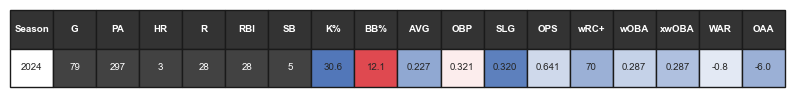

In [53]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define color maps
cmap_sum = mcolors.LinearSegmentedColormap.from_list("", ['#3661AD','#FFFFFF','#D82129'])
cmap_sum_r = mcolors.LinearSegmentedColormap.from_list("", ['#D82129','#FFFFFF','#3661AD'])

# Function to get color
def get_color(value, normalize, cmap):
    color = cmap(normalize(value))
    return mcolors.to_hex(color)

# Update function to apply color mapping
def adv_fangraphs_batter_stats(batter_id: str, ax: plt.Axes, stats: list, season: int, fontsize: int = 20):
    # Convert batter_id to integer to match xMLBAMID type
    batter_id = int(batter_id)
    
    # Filter for the batter
    df_fangraphs_batter = df_fangraphs[df_fangraphs['xMLBAMID'] == batter_id][stats].reset_index(drop=True)
    
    if df_fangraphs_batter.empty:
        print(f"No data found for batter ID {batter_id}")
        return

    # Convert percentage stats
    for stat in stats:
        if '%' in stat:
            df_fangraphs_batter[stat] = df_fangraphs_batter[stat] * 100

    # Format stats based on dictionary
    df_fangraphs_batter.loc[0] = [
        format(float(df_fangraphs_batter[stat].iloc[0]), fangraphs_stats_dict[stat]['format']) 
        for stat in stats
    ]
    
    # Create table
    table_fg = ax.table(cellText=df_fangraphs_batter.values, colLabels=stats, cellLoc='center', bbox=[0.00, 0.0, 1, 1])

    custom_normalization = {
            'AVG': {'vmin': 0.200, 'vmax': 0.320},  # Lower bound for batting average
            'OBP': {'vmin': 0.245, 'vmax': 0.385},
            'SLG': {'vmin': 0.300, 'vmax': 0.500},
            'OPS': {'vmin': 0.450, 'vmax': .950},
            'ISO': {'vmin': 0.075, 'vmax': 0.300},
            'WAR': {'vmin': -6.0, 'vmax': 6.0},  # WAR can go above 10
            'wOBA': {'vmin': 0.230, 'vmax': 0.390},
            'xwOBA': {'vmin': 0.240, 'vmax': 0.395},
            'BABIP': {'vmin': 0.270, 'vmax': 0.330},
            'K%': {'vmin': -32.0, 'vmax': -13.0},  # Flip range for K%
            'BB%': {'vmin': 3.0, 'vmax': 13.0},
            'wRC+': {'vmin': 40, 'vmax': 160},
            'LA': {'vmin': 5.0, 'vmax': 25.0},
            'EV': {'vmin': 85, 'vmax': 94},
            'maxEV': {'vmin': 103, 'vmax': 115},
            'HardHit%': {'vmin': 22.0, 'vmax': 57.0},
            'Barrel%': {'vmin': 1.0, 'vmax': 17.0},
            'Z-Swing%': {'vmin': 60.0, 'vmax': 80.0},
            'O-Swing%': {'vmin': -45.0, 'vmax': -15.0},  # Flip range for O-Swing%
            'O-Contact%': {'vmin': 30.0, 'vmax': 70.0},
            'Z-Contact%': {'vmin': 70.0, 'vmax': 90.0},
            'Chase%': {'vmin': 10.0, 'vmax': 50.0},
            'OAA': {'vmin': -12.0, 'vmax': 12.0},
            'CFR': {'vmin': -10.0, 'vmax': 10.0}
    }

    # Apply color mapping
    for i, stat in enumerate(stats):
        if stat in custom_normalization:
            vmin, vmax = custom_normalization[stat]['vmin'], custom_normalization[stat]['vmax']
            normalize = mcolors.Normalize(vmin=vmin, vmax=vmax)

            stat_value = float(df_fangraphs_batter[stat].iloc[0])

            # Handle flipped stats (like K% and O-Swing%)
            if stat in ['K%', 'O-Swing%']:
                stat_value = -stat_value

            # Use reversed colormap for xwOBA
            cmap = cmap_sum
            color = get_color(stat_value, normalize, cmap)

            # Apply color to the table cell
            table_fg[(1, i)].set_facecolor(color)

    # Adjust text size and headers
    for key, cell in table_fg.get_celld().items():
        if cell._text:
            cell._text.set_fontsize(fontsize)
    
    # Set dark background and white text for header cells
    for i, key in enumerate(stats):
        header_cell = table_fg[0, i]
        header_cell.set_facecolor('#333333')  # Dark background for header
        header_cell._text.set_fontweight('bold')
        header_cell._text.set_color('white')  # White text for the header

    # Apply a lighter dark color to the first six rows of column values, based on column names
    # Ensure that the rows being accessed exist
    num_rows = len(df_fangraphs_batter)
    rows_to_color = min(6, num_rows)  # Ensuring no out-of-range error

    # List of columns that you want to apply the lighter dark color to
    columns_to_color = ['G', 'PA', 'HR', 'R', 'RBI', 'SB']  # Example: Color only these columns

    for row in range(1, rows_to_color + 1):  # For rows 1 to 6 (skip header row 0)
        for col, stat in enumerate(stats):
            if stat in columns_to_color:  # Check if the column is one of the ones we want to color
                cell = table_fg[row, col]
                cell.set_facecolor('#424242')  # Apply a lighter dark background color for these cells
                cell._text.set_color('white')  # Apply white text color for these cells

    ax.axis('off')

stats = ['Season','G', 'PA', 'HR','R','RBI','SB', 'K%', 'BB%','AVG', 'OBP', 'SLG', 'OPS','wRC+','wOBA','xwOBA', 'WAR','OAA']
# Example stats
season = season  # Example season

# Create a subplot for the stats table
fig, ax = plt.subplots(figsize=(10, 1))  # Adjust the size as needed
adv_fangraphs_batter_stats(batter_id=batter_id, ax=ax, stats=stats, season=season)
plt.show()


Gathering Player Data


/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_35831/2862555577.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.287' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_35831/2862555577.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '88.2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_35831/2862555577.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '112.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangra

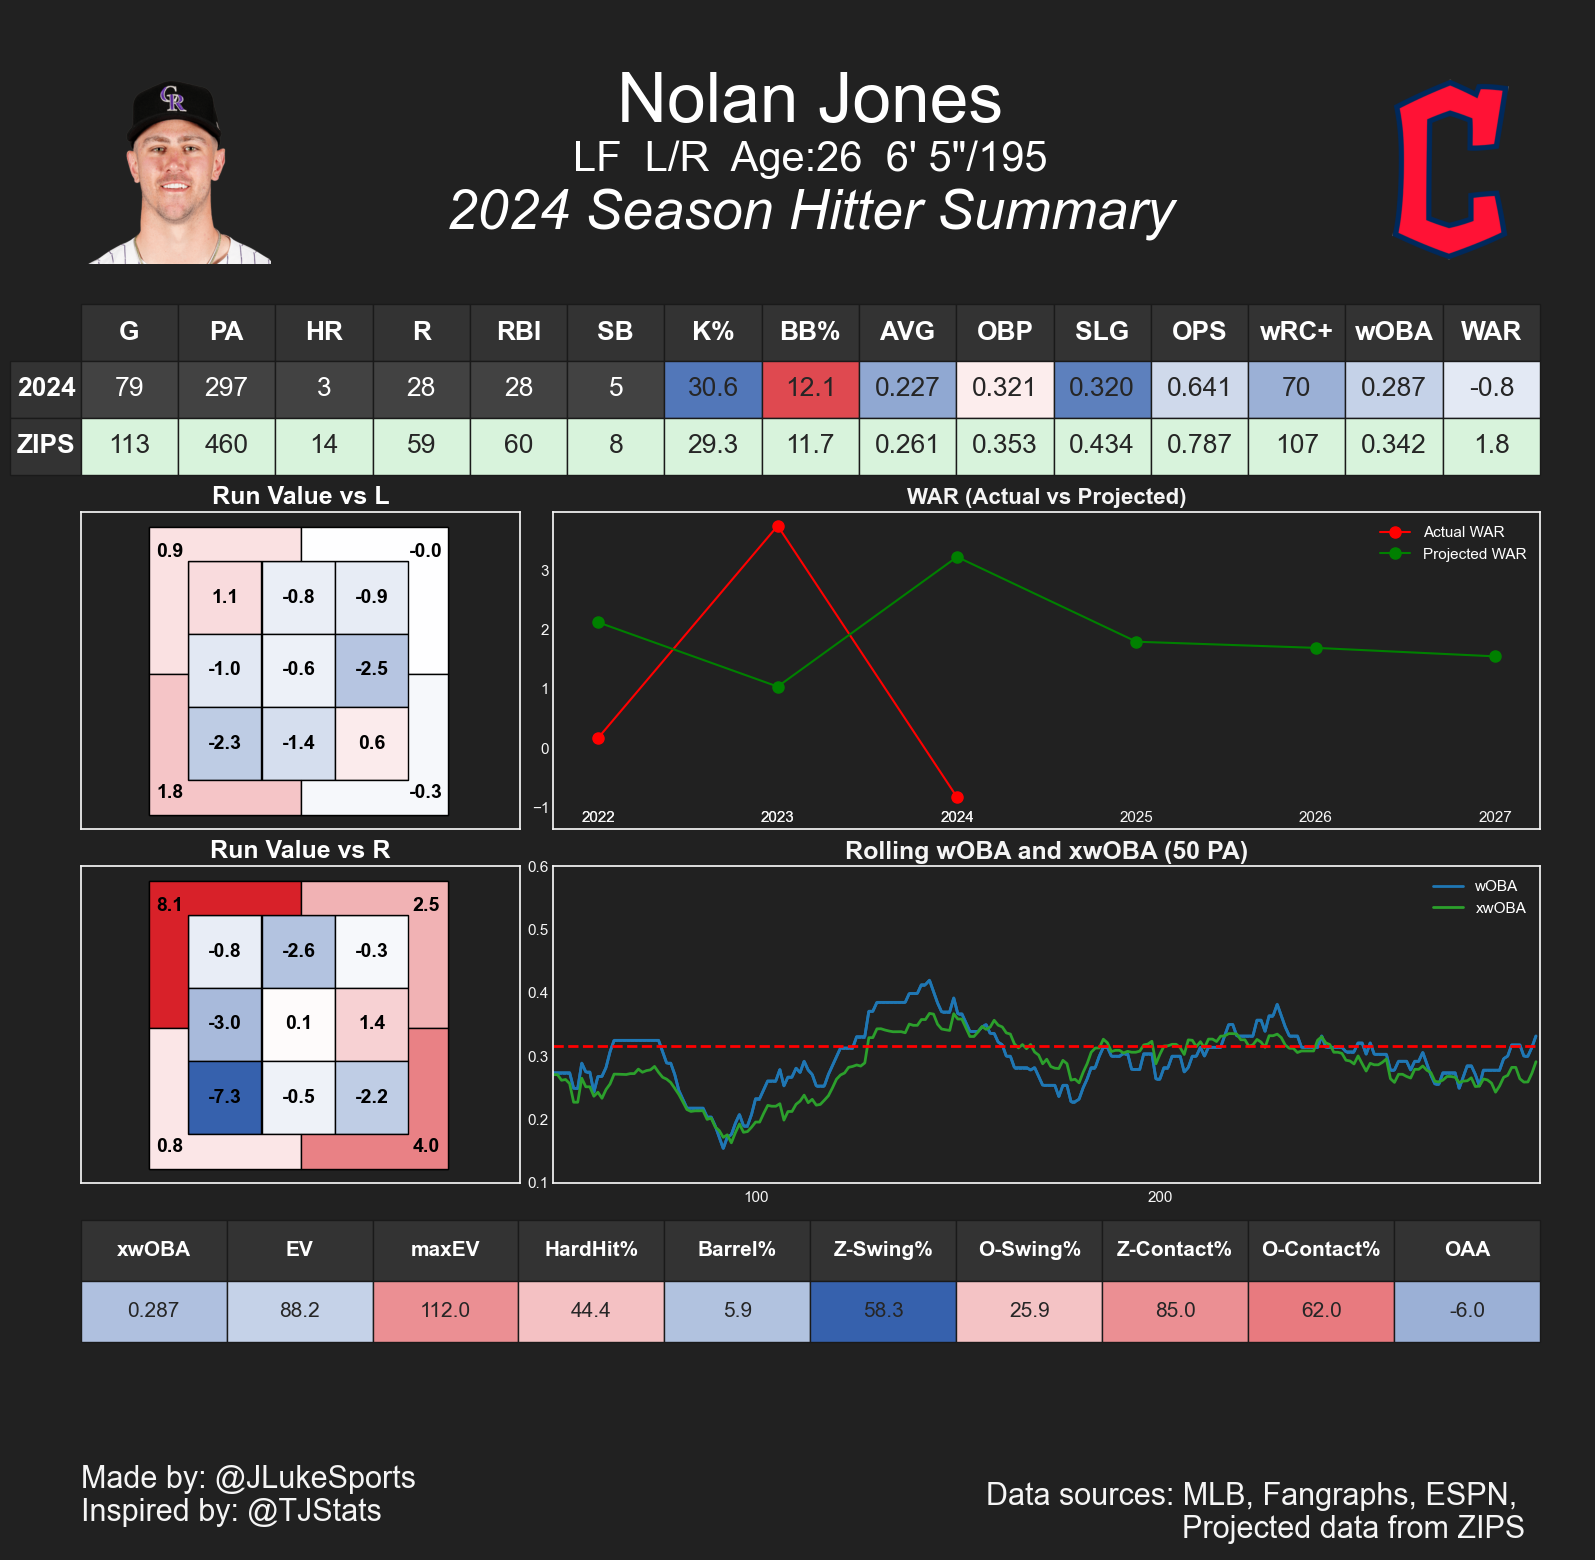

<Figure size 640x480 with 0 Axes>

In [52]:
# Example usageimport matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

def hitting_dashboard(batter_id, df, stats, window, projection_csv, df_actual22, df_actual23, df_actual24, df_ZIPS22, df_ZIPS23, df_ZIPS24, df_ZIPS25, df_ZIPS26, df_ZIPS27):
    # Set dark mode theme globally
    dark_bg = '#212121'  # Dark background color for the entire dashboard
    light_text = '#F5F5F5'  # Light text color for dark mode
    accent_color = '#FF5722'  # Example accent color for headings or specific elements
    dark_gray = '#616161'  # Dark gray for plot background and table borders

    # Set global dark mode settings for the whole dashboard
    mpl.rcParams['axes.facecolor'] = dark_bg  # Dark background for axes
    mpl.rcParams['axes.edgecolor'] = light_text  # Light edge color for axes
    mpl.rcParams['axes.labelcolor'] = light_text  # White labels for axes
    mpl.rcParams['xtick.color'] = light_text  # White ticks for x-axis
    mpl.rcParams['ytick.color'] = light_text  # White ticks for y-axis
    mpl.rcParams['figure.facecolor'] = dark_bg  # Dark background for the entire figure
    mpl.rcParams['figure.edgecolor'] = light_text  # White edge for the entire figure
    mpl.rcParams['font.size'] = 12  # Set default font size
    mpl.rcParams['grid.color'] = 'gray'  # Grid color
    mpl.rcParams['grid.linestyle'] = '--'  # Grid line style

    # Set up the figure and GridSpec for the layout with header and footer
    fig = plt.figure(figsize=(20, 20), facecolor=dark_bg)

    gs = gridspec.GridSpec(7, 8,
                           height_ratios=[1, 8, 7, 13, 13, 5, 7],  # Adjusted heights for sections
                           width_ratios=[1, 20, 13, 13, 13, 23, 23, 1])  # Adjusted width ratios

    # Define subplots with dark background color for the axes
    ax_headshot = fig.add_subplot(gs[1, 1:2], facecolor=dark_bg)
    ax_bio = fig.add_subplot(gs[1, 0:8], facecolor=dark_bg)
    ax_logo = fig.add_subplot(gs[1, 6:8], facecolor=dark_bg)
    ax_season_table = fig.add_subplot(gs[2, 1:7], facecolor=dark_bg)
    ax_season_proj_table = fig.add_subplot(gs[5, 1:7], facecolor=dark_bg)
    ax_plot_1 = fig.add_subplot(gs[3, 1:3], facecolor=dark_bg)
    ax_plot_2 = fig.add_subplot(gs[4, 1:3], facecolor=dark_bg)
    ax_plot_3 = fig.add_subplot(gs[4, 3:7], facecolor=dark_bg)
    ax_plot_4 = fig.add_subplot(gs[3, 3:7], facecolor=dark_bg)
    ax_footer = fig.add_subplot(gs[-1, 1:7], facecolor=dark_bg)
    ax_header = fig.add_subplot(gs[0, 1:7], facecolor=dark_bg)
    ax_left = fig.add_subplot(gs[:, 0], facecolor=dark_bg)
    ax_right = fig.add_subplot(gs[:, -1], facecolor=dark_bg)

    # Hide axes for footer, header, left, and right
    ax_footer.axis('off')
    ax_header.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    # Add Twitter handle and sources in footer
    sources = "Data sources: MLB, Fangraphs, ESPN, \nProjected data from ZIPS"
    ax_footer.text(0, 0.5, 'Made by: @JLukeSports \nInspired by: @TJStats', ha='left', va='top', fontsize=22, color=light_text)

    ax_footer.text(0.99, 0.4, sources,
                   ha='right', va='top',
                   fontsize=22, color=light_text,
                   )

    # Load and display player visuals
    player_headshot(batter_id, ax=ax_headshot)
    player_bio(batter_id, ax=ax_bio)
    plot_logo(batter_id, ax=ax_logo)

    # Display Season Stats Table and Projection Table
    adv_fangraphs_batter_stats(batter_id, ax=ax_season_proj_table, stats=stats, season=season)
    proj_fangraphs_batter_stats(batter_id, ax=ax_season_table, stats=['G', 'PA', 'HR', 'R', 'RBI', 'SB', 'K%', 'BB%', 'AVG', 'OBP', 'SLG', 'OPS', 'wRC+', 'wOBA', 'WAR'], season=season, projection_csv=projection_csv)

    # Plot WAR comparison
    plot_war_comparison(batter_id, df_actual22, df_actual23, df_actual24, df_ZIPS22, df_ZIPS23, df_ZIPS24, df_ZIPS25, df_ZIPS26, df_ZIPS27, ax_plot_4)

    # Plot heatmaps and rolling wOBA
    statcast_run_value_L(df_pyb,ax=ax_plot_1)
    statcast_run_value_R(df_pyb,ax=ax_plot_2)
    rolling_woba_by_pa(df, ax=ax_plot_3, window=window)

    # Set aspect for the heatmap plots
    ax_plot_1.set_aspect('auto')
    ax_plot_2.set_aspect('auto')

    # Adjust title and label spacing
    ax_plot_3.set_title(f'Rolling wOBA ({window} PA)', fontsize=16, pad=30)
    ax_plot_3.set_ylabel('wOBA', fontsize=14, labelpad=20)

    fig.subplots_adjust(hspace=1.0, wspace=1, bottom=0.1)
    plt.tight_layout()
    plt.show()

batter_id = 666134 # Example batter ID
season = season
df_pyb = pyb.statcast_batter('2024-03-28', '2024-10-01', batter_id) # Your dataset
stats = ['xwOBA', 'EV','maxEV','HardHit%','Barrel%', 'Z-Swing%', 'O-Swing%','Z-Contact%','O-Contact%','OAA']  # ADD 'CFR' instead of 'OAA' for Catchers
window = 50  # Example window size for rolling wOBA

# Example call to the dashboard with actual data
hitting_dashboard(batter_id=batter_id, df=df_pyb, stats=stats, window=window, projection_csv="ZIPS_proj2025.csv", df_actual22=df_actual22, df_actual23=df_actual23, df_actual24=df_actual24, df_ZIPS22=df_ZIPS22, df_ZIPS23=df_ZIPS23, df_ZIPS24=df_ZIPS24, df_ZIPS25=df_ZIPS25, df_ZIPS26=df_ZIPS26, df_ZIPS27=df_ZIPS27)


In [48]:
print(pyb.playerid_lookup('Jones','Nolan'))

  name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0     jones      nolan     666134  jonen002  jonesno01          20529   

   mlb_played_first  mlb_played_last  
0            2022.0           2024.0  
